# Проект: Обучение с учителем: качество модели


**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.


«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, намам предстоит побыть в роли стажёра в этом отделеНеобходимоили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активть.

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

## Обзор данных

### Импорт библиотек

Установка необходимых версий:

In [1]:
!pip install numba==0.58.0
!pip install numpy==1.25.2
!pip install scipy==1.11.4
!pip install pandas==2.0.3  
!pip install seaborn==0.13.2
!pip install scikit-learn==1.3.2
!pip install matplotlib==3.9.0
!pip install phik
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import (OneHotEncoder, 
                                    OrdinalEncoder, 
                                    StandardScaler, 
                                    MinMaxScaler, 
                                    LabelEncoder)
from sklearn.metrics import (roc_auc_score,
                             f1_score,
                             recall_score,
                             precision_score,
                             accuracy_score)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Зададим настройки отображения таблиц и графиков

In [3]:
pd.set_option('display.precision', 3)
pd.set_option('display.max_columns', 50)
sns.set_theme(style='whitegrid')

### Обзор данных

In [4]:
user_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
income_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
time_data = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
last_quarter_income_data = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.


- `id` — номер покупателя в корпоративной базе данных.

- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».

- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.

- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
  
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.

- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.

- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.

- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.

- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.

- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.

- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

In [5]:
user_data.head()

id Покупательская активность Тип сервиса Разрешить сообщать  \
0  215348                 Снизилась     премиум                 да   
1  215349                 Снизилась     премиум                 да   
2  215350                 Снизилась   стандартт                нет   
3  215351                 Снизилась   стандартт                 да   
4  215352                 Снизилась   стандартт                нет   

   Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  Акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  Популярная_категория  Средний_просмотр_категорий_за_визит  \
0     Товары для детей                                    6   
1     Товары для детей                                    4   
2    Домашний текстиль                                    5   
3     Товары для детей                                    5   
4     Товары для детей                                    3   

   Неоплаченные_продукты_штук_квартал  Ошибка_сервиса  Страниц_за_визит  
0                                   2               1                 5  
1                                   4               2                 5  
2                                   2               1                 5  
3                                   0               6                 4  
4                                   2               3                 2

In [6]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [7]:
display(user_data.drop(columns='id').describe().T)
user_data.describe(include='object').T

count     mean      std    min     25%  \
Маркет_актив_6_мес                   1300.0    4.254    1.015    0.9    3.70   
Маркет_актив_тек_мес                 1300.0    4.012    0.697    3.0    4.00   
Длительность                         1300.0  601.898  249.856  110.0  405.50   
Акционные_покупки                    1300.0    0.320    0.250    0.0    0.17   
Средний_просмотр_категорий_за_визит  1300.0    3.270    1.355    1.0    2.00   
Неоплаченные_продукты_штук_квартал   1300.0    2.840    1.971    0.0    1.00   
Ошибка_сервиса                       1300.0    4.185    1.955    0.0    3.00   
Страниц_за_визит                     1300.0    8.177    3.978    1.0    5.00   

                                        50%    75%      max  
Маркет_актив_6_мес                     4.20    4.9     6.60  
Маркет_актив_тек_мес                   4.00    4.0     5.00  
Длительность                         606.00  806.0  1079.00  
Акционные_покупки                      0.24    0.3     0.99  
Средний_просмотр_категорий_за_визит    3.00    4.0     6.00  
Неоплаченные_продукты_штук_квартал     3.00    4.0    10.00  
Ошибка_сервиса                         4.00    6.0     9.00  
Страниц_за_визит                       8.00   11.0    20.00

count unique               top freq
Покупательская активность  1300      2   Прежний уровень  802
Тип сервиса                1300      3          стандарт  914
Разрешить сообщать         1300      2                да  962
Популярная_категория       1300      6  Товары для детей  330

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
- `id` — номер покупателя в корпоративной базе данных.

- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'

- `Выручка`  — сумма выручки за период.

In [8]:
income_data.head()

id               Период  Выручка
0  215348  препредыдущий_месяц      0.0
1  215348        текущий_месяц   3293.1
2  215348     предыдущий_месяц      0.0
3  215349  препредыдущий_месяц   4472.0
4  215349        текущий_месяц   4971.6

In [9]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [10]:
display(income_data.drop(columns='id').describe().T)
income_data.describe(include='object').T

count      mean       std  min      25%     50%     75%       max
Выручка  3900.0  5025.696  1777.704  0.0  4590.15  4957.5  5363.0  106862.2

count unique                  top  freq
Период  3900      3  препредыдущий_месяц  1300

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

- `id` — номер покупателя в корпоративной базе данных.

- `Период` — название периода, во время которого зафиксировано общее время.

- `минут` — значение времени, проведённого на сайте, в минутах.

In [11]:
time_data.head()

id            Период  минут
0  215348     текущий_месяц     14
1  215348  предыдцщий_месяц     13
2  215349     текущий_месяц     10
3  215349  предыдцщий_месяц     12
4  215350     текущий_месяц     13

In [12]:
time_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [13]:
display(time_data.drop(columns='id').describe().T)
time_data.describe(include='object').T

count    mean   std  min   25%   50%   75%   max
минут  2600.0  13.336  4.08  4.0  10.0  13.0  16.0  23.0

count unique            top  freq
Период  2600      2  текущий_месяц  1300

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


- `id` — номер покупателя в корпоративной базе данных
  
- `Прибыль` — значение прибыли.

In [14]:
last_quarter_income_data.head()

id  Прибыль
0  215348     0.98
1  215349     4.16
2  215350     3.13
3  215351     4.87
4  215352     4.21

In [15]:
last_quarter_income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [16]:
display(last_quarter_income_data.drop(columns='id').describe().T)

count   mean    std   min  25%    50%   75%   max
Прибыль  1300.0  3.997  1.014  0.86  3.3  4.045  4.67  7.43

Данные соответствуют их описанию.

Явных пропусков нет, типы данных корректные.

### Скорректируем навзания столбцов

Оформим названия столбцов в змеиный стиль со строчными буквами

In [17]:
datasets = [user_data, income_data, time_data, last_quarter_income_data]
datasets_titles = ['user_data', 'income_data', 'time_data', 'last_quarter_income_data']

In [18]:
for df in datasets:
    df.columns = df.columns.str.lower().str.replace(' ', '_')

In [19]:
for df in datasets:
    print(df.columns)

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')
Index(['id', 'период', 'выручка'], dtype='object')
Index(['id', 'период', 'минут'], dtype='object')
Index(['id', 'прибыль'], dtype='object')


Посмотрим мельком на распределение численных признаков 

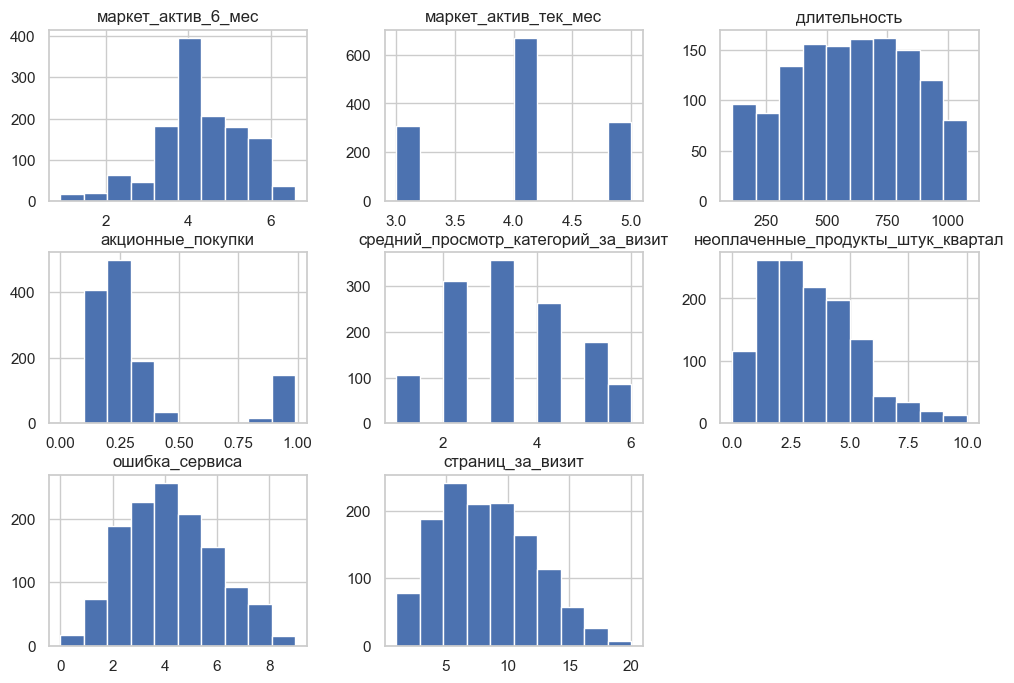

In [20]:
user_data.drop(columns='id').hist(figsize=(12, 8))
plt.show()

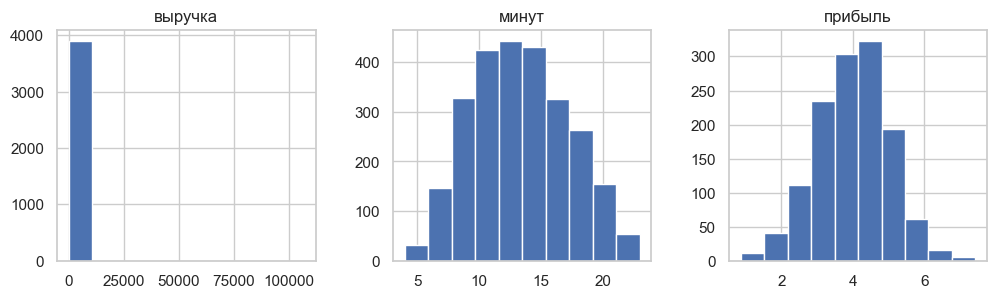

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

income_data.drop(columns='id').hist(ax=ax[0])
time_data.drop(columns='id').hist(ax=ax[1])
last_quarter_income_data.drop(columns='id').hist(ax=ax[2])

plt.show()

### Вывод

- данные соответствуют описанию, типы данных корректны
- явных пропусков нет
- численные данные имеются и непрерывные, и дискретные из ограниченного набора
- в выручке могут быть выбросы

## Предобработка данных

Убедимся ещё раз в отсутствии пропусков в данных

In [22]:
_na = 0

for dataset in datasets:
    _na += dataset.isna().sum().sum()

_na

0

### Дубликаты

In [23]:
for df in datasets:
    print(df.duplicated().sum())

0
0
0
0


Проверим, не могли ли задублироваться данные под разными `id`

In [24]:
for df in datasets:
    print(f"дублей/длина датасета: {df.drop('id', axis=1).duplicated().sum()}/{len(df)}")

дублей/длина датасета: 11/1300
дублей/длина датасета: 746/3900
дублей/длина датасета: 2561/2600
дублей/длина датасета: 900/1300


В последних трёх число стобцов не слишком велико и можно допустить частые совпадения. Однако в первом датасете приличное количество данных по каждому наблюдению, рассмотрим эти повторы детальнее

In [25]:
user_data[user_data.drop('id', axis=1).duplicated(keep=False)].sort_values('длительность').head(6)

id покупательская_активность тип_сервиса разрешить_сообщать  \
551  215899                 Снизилась    стандарт                нет   
341  215689                 Снизилась    стандарт                нет   
347  215695                 Снизилась    стандарт                 да   
557  215905                 Снизилась    стандарт                 да   
548  215896                 Снизилась    стандарт                нет   
338  215686                 Снизилась    стандарт                нет   

     маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
551                 5.0                     4           136   
341                 5.0                     4           136   
347                 4.3                     4           324   
557                 4.3                     4           324   
548                 4.3                     4           460   
338                 4.3                     4           460   

     акционные_покупки            популярная_категория  \
551               0.27                Товары для детей   
341               0.27                Товары для детей   
347               0.14  Техника для красоты и здоровья   
557               0.14  Техника для красоты и здоровья   
548               0.16  Техника для красоты и здоровья   
338               0.16  Техника для красоты и здоровья   

     средний_просмотр_категорий_за_визит  неоплаченные_продукты_штук_квартал  \
551                                    3                                   4   
341                                    3                                   4   
347                                    2                                   7   
557                                    2                                   7   
548                                    2                                   1   
338                                    2                                   1   

     ошибка_сервиса  страниц_за_визит  
551               4                17  
341               4                17  
347               4                 4  
557               4                 4  
548               3                 6  
338               3                 6

После совмещения дублей видим, что разница `id` у них одинакова — 210. Это может говорить о какой-либо технической неполадке. Проверим эти `id` в других датасетах

In [26]:
duplicated_ids = user_data[user_data.drop('id', axis=1).duplicated(keep=False)]['id']

In [27]:
for i in range(4):
    print(f"{datasets_titles[i]:<30} строк/дублей: {len(datasets[i][datasets[i]['id'].isin(duplicated_ids)])}/\
{datasets[i][datasets[i]['id'].isin(duplicated_ids)].drop(columns=['id']).duplicated(keep=False).sum()}")

user_data                      строк/дублей: 22/22
income_data                    строк/дублей: 66/66
time_data                      строк/дублей: 44/44
last_quarter_income_data       строк/дублей: 22/0


In [28]:
last_quarter_income_data_duplicates = (
    last_quarter_income_data[last_quarter_income_data['id'].isin(duplicated_ids)].sort_values('id')
)

last_quarter_income_data_duplicates = pd.concat(
    [last_quarter_income_data_duplicates.head(11).reset_index(drop=True), 
     last_quarter_income_data_duplicates.tail(11).reset_index(drop=True)],
    axis=1
)

In [29]:
last_quarter_income_data_duplicates

id  прибыль      id  прибыль
0   215685     4.33  215895     5.16
1   215686     3.07  215896     3.73
2   215687     3.68  215897     6.24
3   215688     2.88  215898     3.10
4   215689     4.65  215899     5.26
5   215690     5.66  215900     4.19
6   215691     4.28  215901     3.85
7   215692     2.09  215902     4.32
8   215693     3.56  215903     4.55
9   215694     2.41  215904     2.35
10  215695     4.36  215905     3.43

Что имеем: в 3 из 4 датасетах повторяются данные для 11 `id`, при этом замечена точная разность в числе `id` для всех дублей. Однако, в последнем датасете различные значения прибыли, какая-либо зависимость между ними не прослеживается. Ввиду этого отличия оставим данные как есть

Число категорий в каждом признаке невелико, проверим их значения

In [30]:
for df in datasets:
    for col in df.select_dtypes(exclude='number'):
        print(col)
        print(df[col].unique(), '\n')

покупательская_активность
['Снизилась' 'Прежний уровень'] 

тип_сервиса
['премиум' 'стандартт' 'стандарт'] 

разрешить_сообщать
['да' 'нет'] 

популярная_категория
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника'] 

период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц'] 

период
['текущий_месяц' 'предыдцщий_месяц'] 



В тип сервиса затесался неявный дубликат. Исправим его и другие грамматические ошибки, а также заменим прописные буквы на строчные

In [31]:
mapper = {
    'стандартт': 'стандарт',
    'Косметика и аксесуары': 'косметика и аксессуары',
    'предыдцщий_месяц': 'предыдущий_месяц'
}

In [32]:
for df in datasets:
    for col in df.select_dtypes(exclude='number'):
        print(col)
        df[col] = df[col].replace(mapper).str.lower()
        print(df[col].unique(), '\n')

покупательская_активность
['снизилась' 'прежний уровень'] 

тип_сервиса
['премиум' 'стандарт'] 

разрешить_сообщать
['да' 'нет'] 

популярная_категория
['товары для детей' 'домашний текстиль' 'косметика и аксессуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника'] 

период
['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц'] 

период
['текущий_месяц' 'предыдущий_месяц'] 



### Типы данных

Типы `object` заменим на `category`

In [33]:
for df in datasets:
    columns_to_change_type = df.select_dtypes(include='object').columns 
    df[columns_to_change_type] = df[columns_to_change_type].astype('category')

Посмотрим на результат

In [34]:
for df in datasets:
    df.info()
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   category
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

### Итог предобработки

1. В данных найдено небольшое количество пользователей, схожих по всем признакам, кроме прибыли. Только из-за одного отличия принято решение их оставить, однако стоит уточнить у коллег, не закралась ли здесь ошибка/сбой.
2. В категориальных переменных обнаружены и исправлены грамматические ошибки.

## Исследовательский анализ

### Коммуникация с клиентом

In [35]:
cat_communication = ['тип_сервиса', 'разрешить_сообщать']

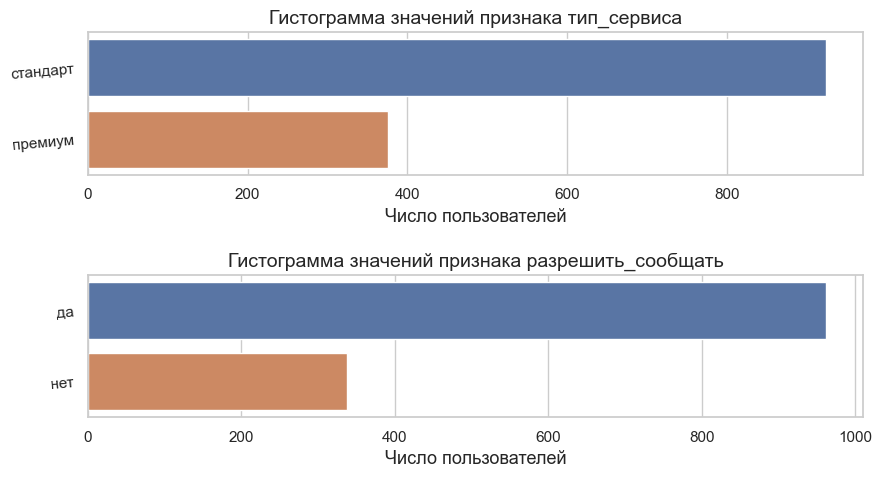

In [36]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
fig.subplots_adjust(hspace=0.7)

for i in range(2):    
    sns.barplot(
        user_data[cat_communication[i]].value_counts().to_frame().T,
        orient='h',
        ax=axes[i])
    axes[i].set_ylabel('')
    axes[i].set_title(f"Гистограмма значений признака {cat_communication[i]}", fontsize=14)
    axes[i].tick_params(axis='y', rotation=5)
    axes[i].set_xlabel('Число пользователей', fontsize=13)

plt.show()

Численные признаки:

In [37]:
user_data[['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность']].describe().round(2)

маркет_актив_6_мес  маркет_актив_тек_мес  длительность
count             1300.00               1300.00       1300.00
mean                 4.25                  4.01        601.90
std                  1.01                  0.70        249.86
min                  0.90                  3.00        110.00
25%                  3.70                  4.00        405.50
50%                  4.20                  4.00        606.00
75%                  4.90                  4.00        806.00
max                  6.60                  5.00       1079.00

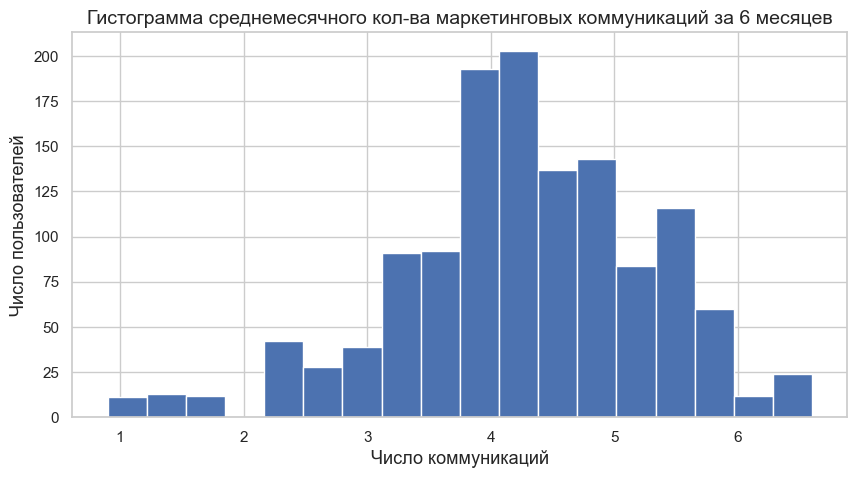

In [38]:
plt.figure(figsize=(10, 5))

user_data['маркет_актив_6_мес'].hist(bins=18)

plt.title('Гистограмма среднемесячного кол-ва маркетинговых коммуникаций за 6 месяцев', fontsize=14)
plt.xlabel('Число коммуникаций', fontsize=13)
plt.ylabel('Число пользователей', fontsize=13)
plt.show()

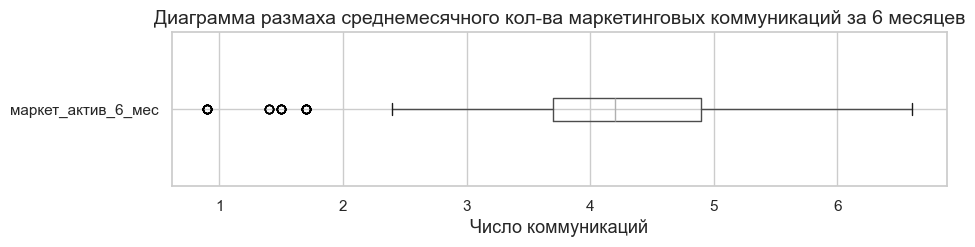

In [39]:
plt.figure(figsize=(10, 2))

user_data.boxplot('маркет_актив_6_мес', vert=False)
plt.title('Диаграмма размаха среднемесячного кол-ва маркетинговых коммуникаций за 6 месяцев', fontsize=14)
plt.xlabel('Число коммуникаций', fontsize=13)

plt.show()

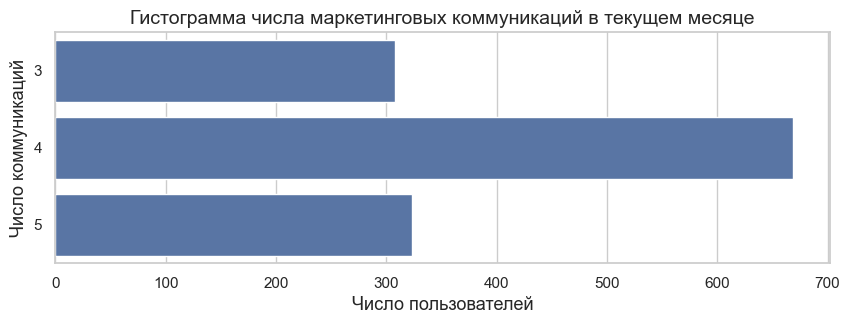

In [40]:
plt.figure(figsize=(10, 3))

sns.barplot(user_data['маркет_актив_тек_мес'].value_counts(), width=0.8, orient='h')

plt.title('Гистограмма числа маркетинговых коммуникаций в текущем месяце', fontsize=14)
plt.ylabel('Число коммуникаций', fontsize=13)
plt.xlabel('Число пользователей', fontsize=13)
plt.show()

По обеим гистограммам видим, что в среднем пользователям отправляют 3-6 предложений в месяц. Выделяется небольшая часть пользователей со среднемесячными значениями ниже 3

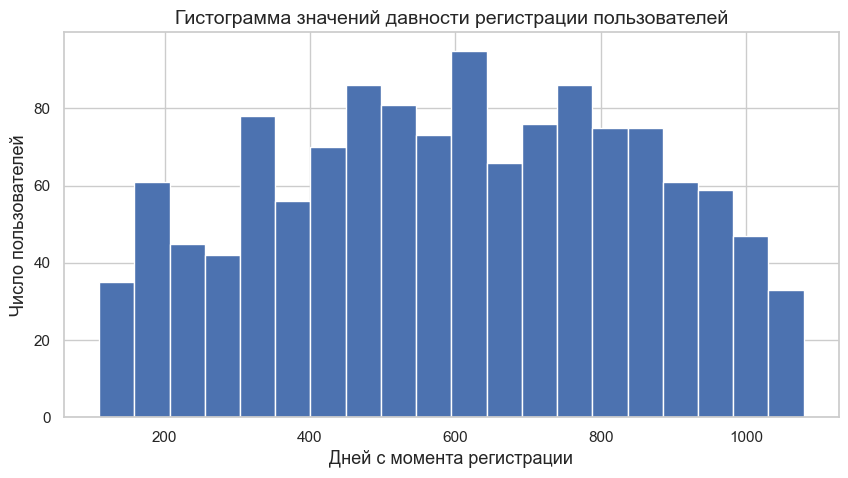

In [41]:
plt.figure(figsize=(10, 5))

user_data['длительность'].hist(bins=20)

plt.title('Гистограмма значений давности регистрации пользователей', fontsize=14)
plt.xlabel('Дней с момента регистрации', fontsize=13)
plt.ylabel('Число пользователей', fontsize=13)
plt.show()

Признак `длительность` распределён достаточно равномерно. Есть немало и старых, и относительно новых пользователей

### Продуктовое поведение

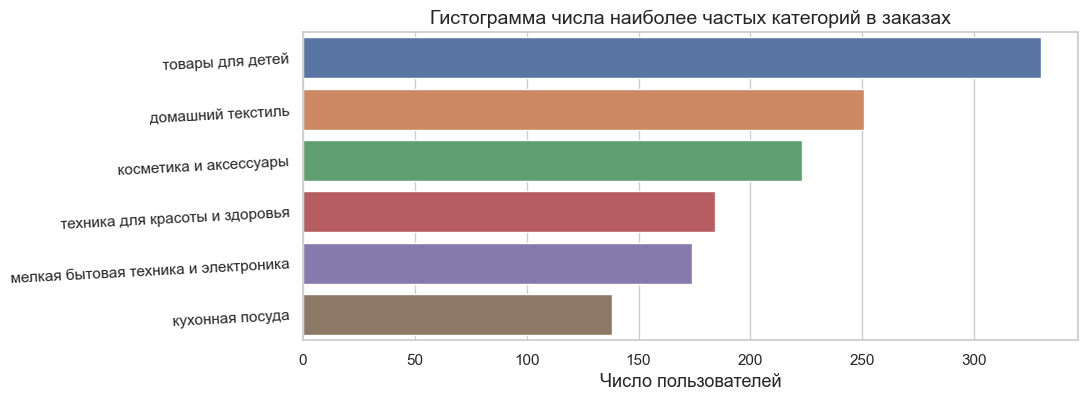

In [42]:
plt.figure(figsize=(10, 4))

sns.barplot(user_data['популярная_категория'].value_counts().to_frame().T,
    orient='h')
plt.xlabel('Число пользователей', fontsize=13)
plt.ylabel('')
plt.title("Гистограмма числа наиболее частых категорий в заказах", fontsize=14)
plt.tick_params(axis='y', rotation=3)

plt.show()

Разброс между категориями не члишком высок, ~ 1.5 относительно среднего, наибольшая превышает наименьшую немного больше, чем 2 раза.

Численные признаки: 

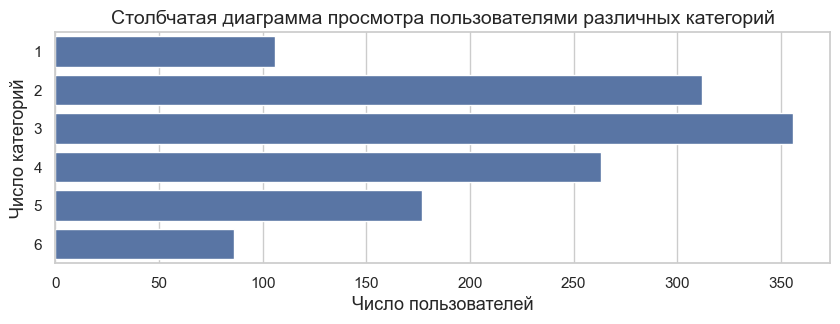

In [43]:
plt.figure(figsize=(10, 3))

sns.barplot(user_data['средний_просмотр_категорий_за_визит'].value_counts(), width=0.8, orient='h')

plt.title('Столбчатая диаграмма просмотра пользователями различных категорий', fontsize=14)
plt.ylabel('Число категорий', fontsize=13)
plt.xlabel('Число пользователей', fontsize=13)
plt.show()

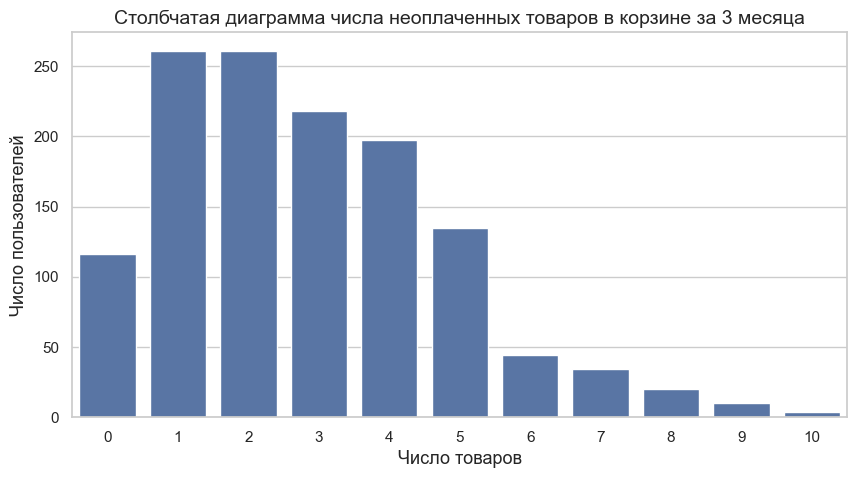

In [44]:
plt.figure(figsize=(10, 5))

sns.barplot(user_data['неоплаченные_продукты_штук_квартал'].value_counts(), width=0.8, orient='v')

plt.title('Столбчатая диаграмма числа неоплаченных товаров в корзине за 3 месяца', fontsize=14)
plt.ylabel('Число пользователей', fontsize=13)
plt.xlabel('Число товаров', fontsize=13)
plt.show()

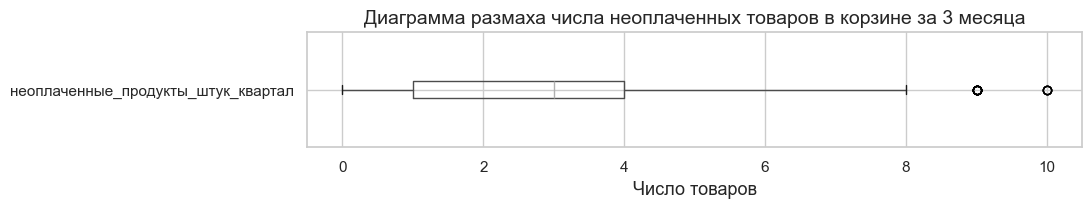

In [45]:
plt.figure(figsize=(10, 1.5))

user_data.boxplot('неоплаченные_продукты_штук_квартал', vert=False)
plt.title('Диаграмма размаха числа неоплаченных товаров в корзине за 3 месяца', fontsize=14)
plt.xlabel('Число товаров', fontsize=13)

plt.show()

У бОльшей части от 0 до 5 товаров в корзине оставались неоплаченными. Часть пользователей с кол-вом от 6 до 10 можно считать довольно редкой

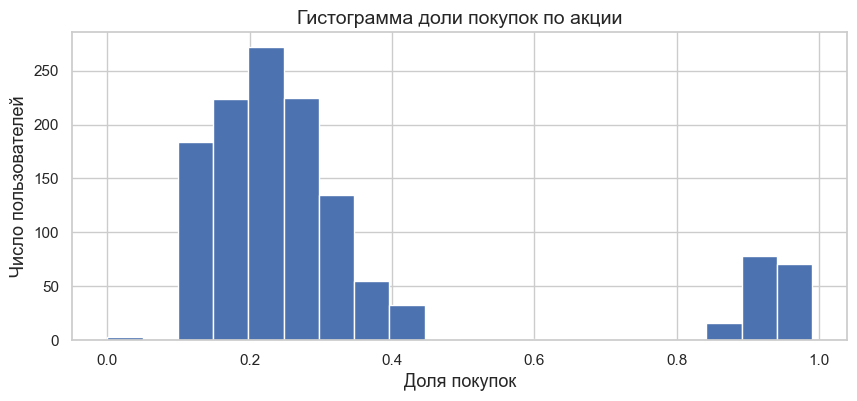

In [46]:
plt.figure(figsize=(10, 4))

user_data['акционные_покупки'].hist(bins=20)

plt.title('Гистограмма доли покупок по акции', fontsize=14)
plt.xlabel('Доля покупок', fontsize=13)
plt.ylabel('Число пользователей', fontsize=13)
plt.show()

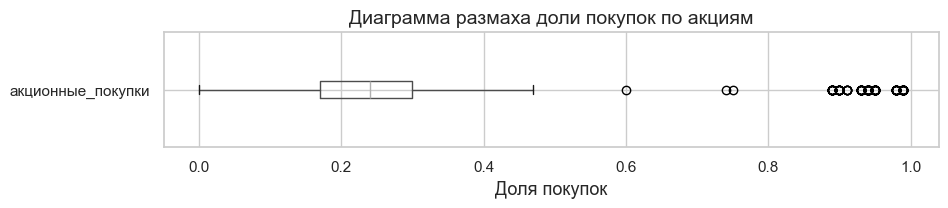

In [47]:
plt.figure(figsize=(10, 1.5))

user_data.boxplot('акционные_покупки', vert=False)
plt.title('Диаграмма размаха доли покупок по акциям', fontsize=14)
plt.xlabel('Доля покупок', fontsize=13)

plt.show()

Наблюдаем разделение на 2 группы: одни брали ~ от 10% до 45% товаров по акциям, другие ~ от 80% до 100%

### Поведение на сайте

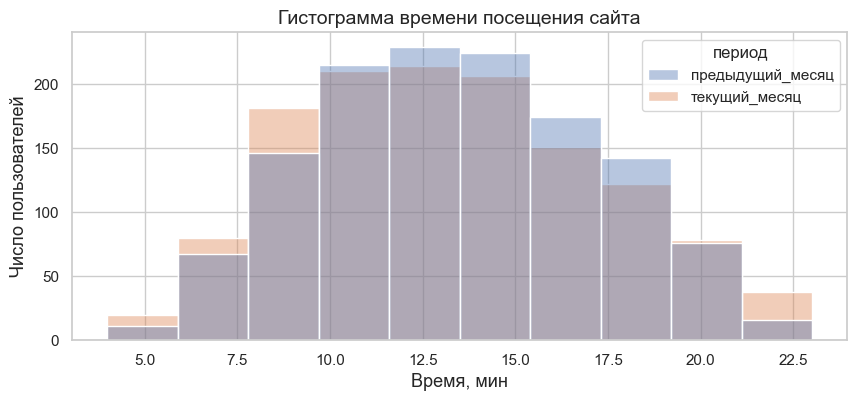

In [48]:
plt.figure(figsize=(10, 4))

sns.histplot(time_data, x='минут', hue='период', bins=10, alpha=0.4)

plt.title('Гистограмма времени поcещения сайта', fontsize=14)
plt.xlabel('Время, мин', fontsize=13)
plt.ylabel('Число пользователей', fontsize=13)
plt.show()

In [49]:
time_data.groupby('период')['минут'].describe()

count    mean    std  min   25%   50%   75%   max
период                                                              
предыдущий_месяц  1300.0  13.468  3.932  5.0  11.0  13.0  17.0  23.0
текущий_месяц     1300.0  13.205  4.221  4.0  10.0  13.0  16.0  23.0

По гистограмме заметно некоторое снижение времени посещения в текущем месяце. Хотя небольшая часть пользователей, наобороот, провела времени ощутимо больше, чем в предыдущем

In [50]:
user_data[['страниц_за_визит', 'ошибка_сервиса']].describe().round(1)

страниц_за_визит  ошибка_сервиса
count            1300.0          1300.0
mean                8.2             4.2
std                 4.0             2.0
min                 1.0             0.0
25%                 5.0             3.0
50%                 8.0             4.0
75%                11.0             6.0
max                20.0             9.0

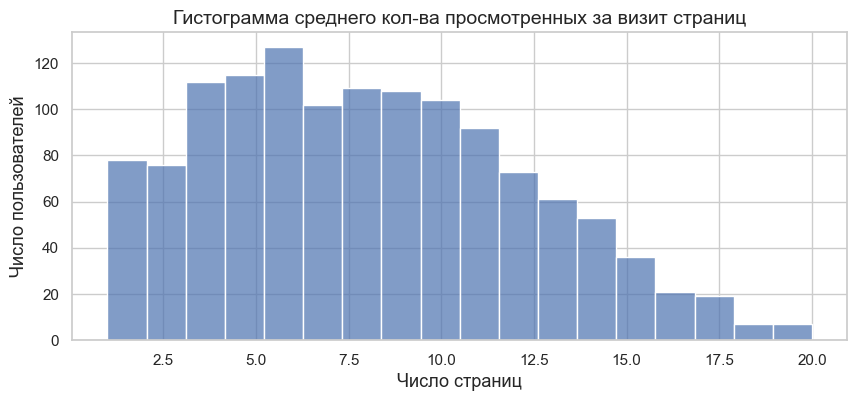

In [51]:
plt.figure(figsize=(10, 4))

sns.histplot(user_data, x='страниц_за_визит', bins='auto', alpha=0.7)

plt.title('Гистограмма среднего кол-ва просмотренных за визит страниц', fontsize=14)
plt.xlabel('Число страниц', fontsize=13)
plt.ylabel('Число пользователей', fontsize=13)
plt.show()

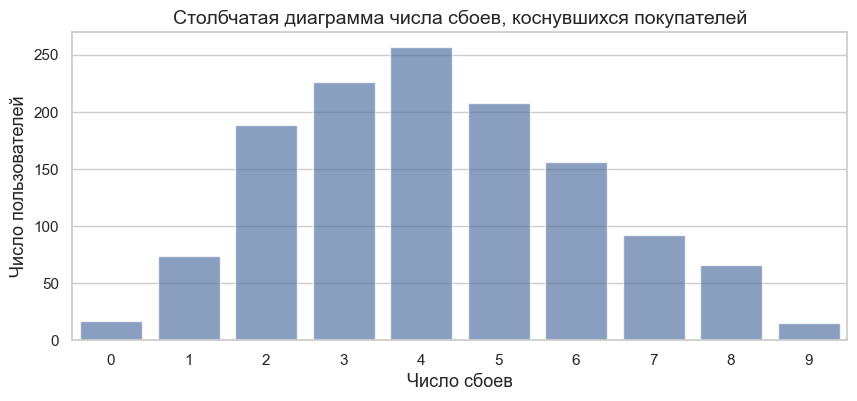

In [52]:
plt.figure(figsize=(10, 4))

sns.barplot(user_data['ошибка_сервиса'].value_counts(), alpha=0.7)

plt.title('Столбчатая диаграмма числа сбоев, коснувшихся покупателей', fontsize=14)
plt.xlabel('Число сбоев', fontsize=13)
plt.ylabel('Число пользователей', fontsize=13)
plt.show()

Гистограмма просмотра страниц и диаграмма сбоев не примечательны чем-либо. Распределения Пуассоновское и нормальное

### Финансовое поведение

In [53]:
income_data.groupby('период')['выручка'].describe().round()

count    mean     std     min     25%     50%     75%  \
период                                                                        
предыдущий_месяц     1300.0  4937.0   740.0     0.0  4497.0  5005.0  5406.0   
препредыдущий_месяц  1300.0  4825.0   406.0     0.0  4583.0  4809.0  5054.0   
текущий_месяц        1300.0  5315.0  2940.0  2759.0  4706.0  5180.0  5762.0   

                          max  
период                         
предыдущий_месяц       6870.0  
препредыдущий_месяц    5663.0  
текущий_месяц        106862.0

In [54]:
income_data.sort_values('выручка').tail()

id         период   выручка
2388  216144  текущий_месяц    7547.8
1481  215841  текущий_месяц    7557.0
262   215435  текущий_месяц    7605.3
435   215493  текущий_месяц    7799.4
98    215380  текущий_месяц  106862.2

Данные о выручке от одного пользователя за текущий месяц сильно выделяются. Вне зависимости от причины такого значения (ошибка записи или действительный выброс) удалим информацию об этом пользователе, чтобы не исказить исследование

In [55]:
income_data = income_data.drop(income_data[income_data['id'] == 215380].index)
len(income_data)

3897

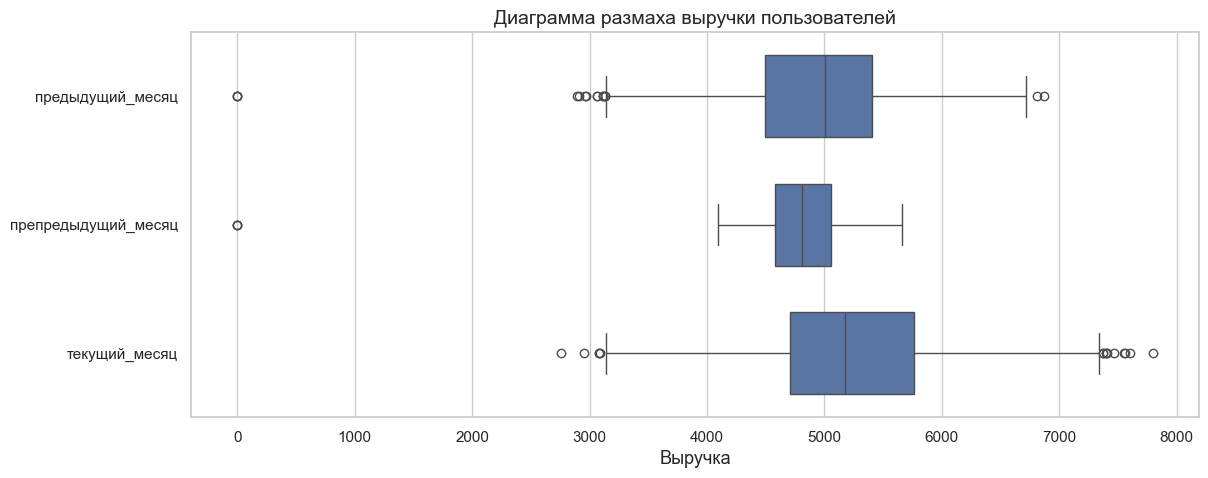

In [56]:
plt.figure(figsize=(13, 5))

# sns.violinplot(income_data, x='выручка', hue='период', width=0.8, gap=0.2)
sns.boxplot(income_data, x='выручка', y='период', width=0.8, gap=0.2)

plt.title('Диаграмма размаха выручки пользователей', fontsize=14)
plt.xlabel('Выручка', fontsize=13)
plt.ylabel('', fontsize=13)
plt.show()

In [57]:
income_data.sort_values('выручка').head(7)

id               период  выручка
0    215348  препредыдущий_месяц      0.0
2    215348     предыдущий_месяц      0.0
35   215359  препредыдущий_месяц      0.0
34   215359     предыдущий_месяц      0.0
29   215357     предыдущий_месяц      0.0
28   215357  препредыдущий_месяц      0.0
356  215466        текущий_месяц   2758.7

3 пользователя в предыдущие 2 месяца  не своершали покупок. Это также является выбросом для исследования, т.к. проблематично оценивать изменение их покупательской активности. Уберём их из датасета

In [58]:
zero_income_ids = income_data[income_data['выручка'] == 0]['id'].to_list()
zero_income_ids

[215348, 215348, 215357, 215357, 215359, 215359]

In [59]:
print(len(income_data))
income_data = income_data.drop(income_data[income_data['id'].isin(zero_income_ids)].index)
len(income_data)

3897


3888

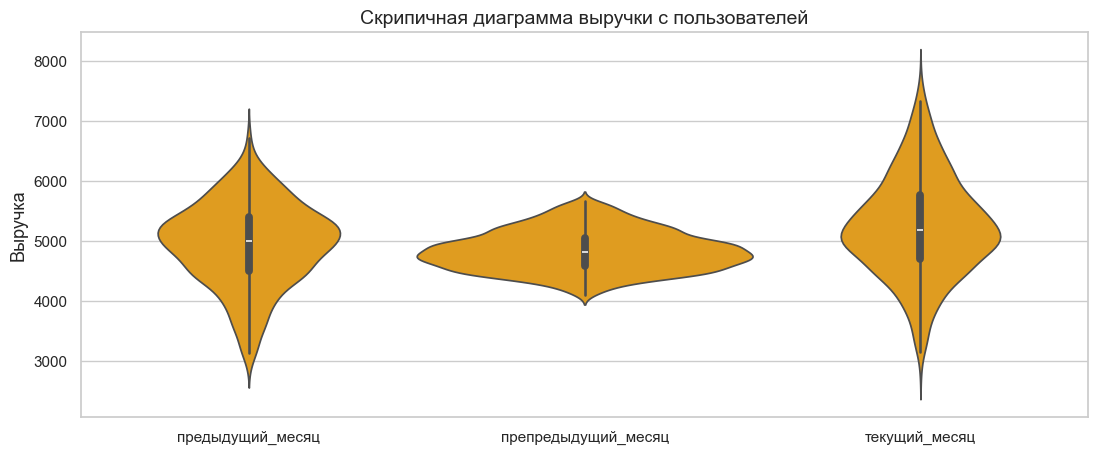

In [60]:
plt.figure(figsize=(13, 5))

sns.violinplot(income_data, y='выручка', x='период', inner='box', color='orange', width=1)
# sns.boxplot(income_data, x='выручка', hue='период', width=0.8, gap=0.2)

plt.title('Скрипичная диаграмма выручки с пользователей', fontsize=14)
plt.ylabel('Выручка', fontsize=13)
plt.xlabel('', fontsize=13)
plt.show()

In [61]:
income_data.groupby('период')['выручка'].describe().round()

count    mean    std     min     25%     50%     75%  \
период                                                                       
предыдущий_месяц     1296.0  4947.0  701.0  2890.0  4498.0  5006.0  5406.0   
препредыдущий_месяц  1296.0  4836.0  334.0  4098.0  4584.0  4810.0  5056.0   
текущий_месяц        1296.0  5238.0  834.0  2759.0  4706.0  5180.0  5759.0   

                        max  
период                       
предыдущий_месяц     6870.0  
препредыдущий_месяц  5663.0  
текущий_месяц        7799.0

In [62]:
income_data.pivot_table(index='период', values='выручка', aggfunc='sum').style.format('{:,.0f}')

Средняя, медианная и общая выручка растут за последние месяцы. Однако в последние 2 месяца отмечатся больший разброс

Рассмотрим также разницы в доходе смежных месяцев

In [63]:
income_data_new = income_data.pivot(index='id', columns='период', values='выручка')
income_data_new['2-1'] = income_data_new['предыдущий_месяц'] - income_data_new['препредыдущий_месяц']
income_data_new['2-1_характер'] = income_data_new['2-1'].apply(lambda x: 'рост' if x > 0 else 'снижение')
income_data_new['3-2'] = income_data_new['текущий_месяц'] - income_data_new['предыдущий_месяц']
income_data_new['3-2_характер'] = income_data_new['3-2'].apply(lambda x: 'рост' if x > 0 else 'снижение')
income_data_new.head()

период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц     2-1  \
id                                                                     
215349            5216.0               4472.0         4971.6   744.0   
215350            5457.5               4826.0         5058.4   631.5   
215351            6158.0               4793.0         6610.4  1365.0   
215352            5807.5               4594.0         5872.5  1213.5   
215353            4738.5               5124.0         5388.5  -385.5   

период 2-1_характер    3-2 3-2_характер  
id                                       
215349         рост -244.4     снижение  
215350         рост -399.1     снижение  
215351         рост  452.4         рост  
215352         рост   65.0         рост  
215353     снижение  650.0         рост

In [64]:
income_data_new[['2-1', '3-2']].describe().round(1)

период     2-1     3-2
count   1296.0  1296.0
mean     111.3   290.6
std      670.2   453.8
min    -1999.0 -2610.3
25%     -339.0   -20.8
50%      105.8   287.3
75%      577.9   611.6
max     2067.0  1446.9

Всё так же наблюдаем рост средних показателей

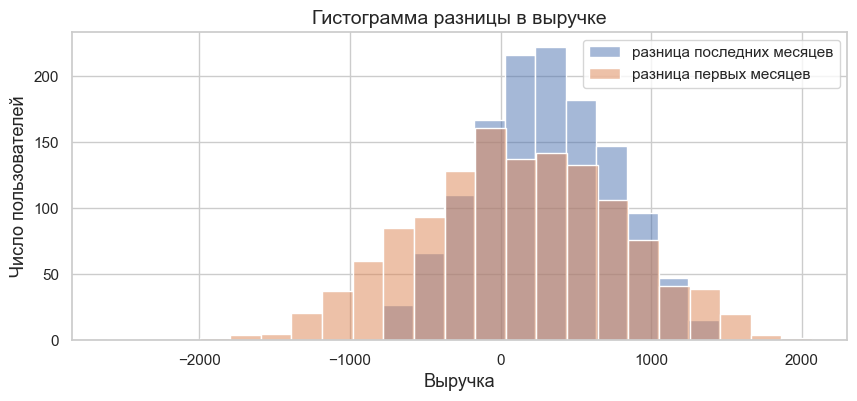

In [65]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.histplot(income_data_new['3-2'], 
             bins=20, alpha=0.5, ax=ax, label='разница последних месяцев')
sns.histplot(income_data_new['2-1'], 
             bins=20, alpha=0.5, ax=ax, label='разница первых месяцев')

plt.title('Гистограмма разницы в выручке', fontsize=14)
plt.legend()
plt.xlabel('Выручка', fontsize=13)
plt.ylabel('Число пользователей', fontsize=13)
plt.show()

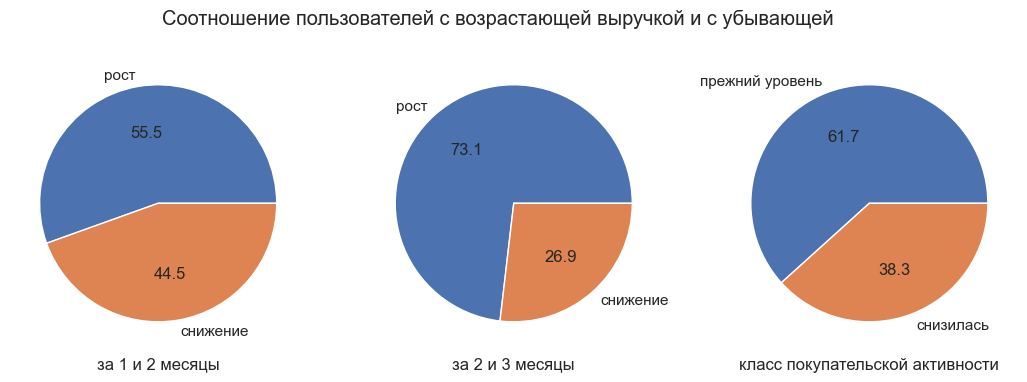

In [66]:
fig, ax = plt.subplots(1, 3,figsize=(13, 4))
plt.suptitle('Соотношение пользователей с возрастающей выручкой и с убывающей')
    
income_data_new['2-1_характер'].value_counts().plot.pie(ax=ax[0], autopct='%.1f')
ax[0].set_xlabel('за 1 и 2 месяцы')
ax[0].set_ylabel('')

income_data_new['3-2_характер'].value_counts().plot.pie(ax=ax[1], autopct='%.1f')
ax[1].set_xlabel('за 2 и 3 месяцы')
ax[1].set_ylabel('')

user_data['покупательская_активность'].value_counts().plot.pie(ax=ax[2], autopct='%.1f')
ax[2].set_xlabel('класс покупательской активности')
ax[2].set_ylabel('')

plt.show()

Хоть и был отмечен рост после каждого месяца, после 1-го всё же у большой части пользователей, практически у половины, было снижение во втором. После 3-го же снижение произошло у много меньшей части ~ 1/4 пользователей.

Метки о снижении активности в итоге отмечены у 38%

### Итог исследовательского анализа

1. Изучены распределения признаков.
2. Из датасета с выручкой удалены 3 пользователя, не совершавшие покупок хотя бы 1 месяц. Также удалён выброс: пользователь со слишком высокой выручкой за один из месяцев.

## Объединение данных

Объединим `user_data`, `time_data` и `income_data`.

`time_data` для начала преобразуем

In [67]:
time_data_pivot = time_data.pivot_table(index='id', columns='период', values='минут')
time_data_pivot.head()

период  предыдущий_месяц  текущий_месяц
id                                     
215348                13             14
215349                12             10
215350                 8             13
215351                11             13
215352                 8             11

In [68]:
user_data.shape, time_data_pivot.shape

((1300, 13), (1300, 2))

In [69]:
data_full = user_data.merge(time_data_pivot, on='id', how='left')

In [70]:
data_full.head()

id покупательская_активность тип_сервиса разрешить_сообщать  \
0  215348                 снизилась     премиум                 да   
1  215349                 снизилась     премиум                 да   
2  215350                 снизилась    стандарт                нет   
3  215351                 снизилась    стандарт                 да   
4  215352                 снизилась    стандарт                нет   

   маркет_актив_6_мес  маркет_актив_тек_мес  длительность  акционные_покупки  \
0                 3.4                     5           121               0.00   
1                 4.4                     4           819               0.75   
2                 4.9                     3           539               0.14   
3                 3.2                     5           896               0.99   
4                 5.1                     3          1064               0.94   

  популярная_категория  средний_просмотр_категорий_за_визит  \
0     товары для детей                                    6   
1     товары для детей                                    4   
2    домашний текстиль                                    5   
3     товары для детей                                    5   
4     товары для детей                                    3   

   неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
0                                   2               1                 5   
1                                   4               2                 5   
2                                   2               1                 5   
3                                   0               6                 4   
4                                   2               3                 2   

   предыдущий_месяц  текущий_месяц  
0                13             14  
1                12             10  
2                 8             13  
3                11             13  
4                 8             11

In [71]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1300 non-null   int64   
 1   покупательская_активность            1300 non-null   category
 2   тип_сервиса                          1300 non-null   category
 3   разрешить_сообщать                   1300 non-null   category
 4   маркет_актив_6_мес                   1300 non-null   float64 
 5   маркет_актив_тек_мес                 1300 non-null   int64   
 6   длительность                         1300 non-null   int64   
 7   акционные_покупки                    1300 non-null   float64 
 8   популярная_категория                 1300 non-null   category
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64   
 11  ошибка_сервиса   

Т.к. из `income_data` удаляли выбросы, соединять будем по `id` из этого датасета. Сразу воспользуемся его преобразованной версией `income_data_new`

In [72]:
print(income_data_new.shape)
income_data_new.head(2)

(1296, 7)


период  предыдущий_месяц  препредыдущий_месяц  текущий_месяц    2-1  \
id                                                                    
215349            5216.0               4472.0         4971.6  744.0   
215350            5457.5               4826.0         5058.4  631.5   

период 2-1_характер    3-2 3-2_характер  
id                                       
215349         рост -244.4     снижение  
215350         рост -399.1     снижение

In [73]:
income_columns_to_merge = ['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']

In [74]:
data_full = data_full.merge(
    income_data_new[income_columns_to_merge], on='id', how='right',
    suffixes=('_время', '_выручка')
).rename({'препредыдущий_месяц': 'препредыдущий_месяц_выручка'}, axis=1)

`id` сделаем индексами 

In [75]:
data_full = data_full.set_index('id')

In [76]:
data_full.head(2)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 снизилась     премиум                 да   
215350                 снизилась    стандарт                нет   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   

        акционные_покупки популярная_категория  \
id                                               
215349               0.75     товары для детей   
215350               0.14    домашний текстиль   

        средний_просмотр_категорий_за_визит  \
id                                            
215349                                    4   
215350                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   

        предыдущий_месяц_время  текущий_месяц_время  \
id                                                    
215349                      12                   10   
215350                       8                   13   

        препредыдущий_месяц_выручка  предыдущий_месяц_выручка  \
id                                                              
215349                       4472.0                    5216.0   
215350                       4826.0                    5457.5   

        текущий_месяц_выручка  
id                             
215349                 4971.6  
215350                 5058.4

In [77]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   покупательская_активность            1296 non-null   category
 1   тип_сервиса                          1296 non-null   category
 2   разрешить_сообщать                   1296 non-null   category
 3   маркет_актив_6_мес                   1296 non-null   float64 
 4   маркет_актив_тек_мес                 1296 non-null   int64   
 5   длительность                         1296 non-null   int64   
 6   акционные_покупки                    1296 non-null   float64 
 7   популярная_категория                 1296 non-null   category
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64   
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64   
 10  ошибка_сервиса                       1296 non-null   int64   
 11  страниц_за_визи

## Корреляционный анализ

### Общее сравнение

In [78]:
numeric_columns = data_full.select_dtypes(include='number').columns
categorial_columns = data_full.select_dtypes(exclude='number').columns

In [79]:
target = 'покупательская_активность'

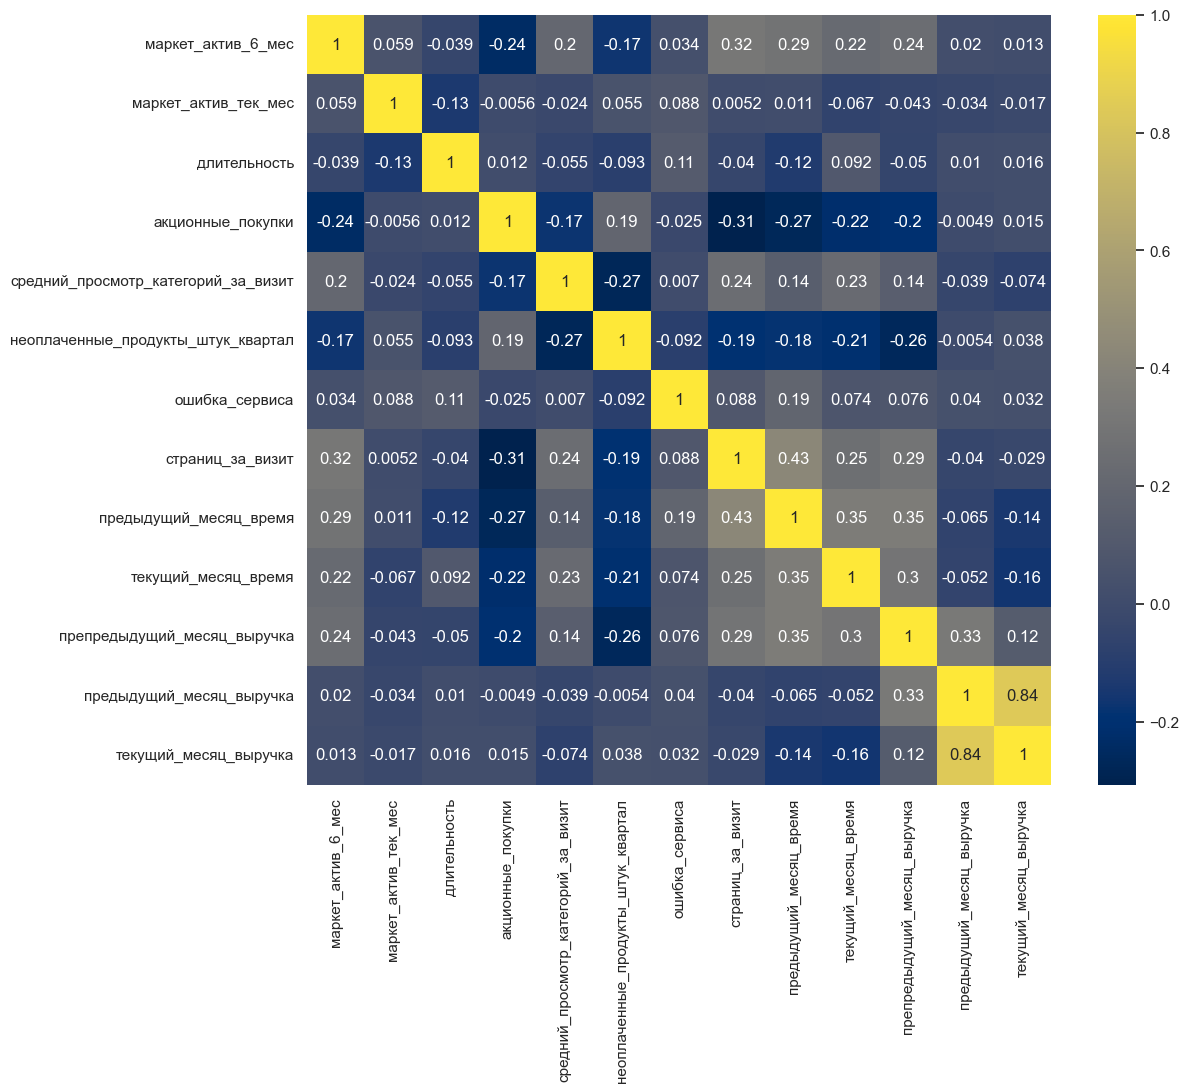

In [80]:
plt.figure(figsize=(12, 10))

sns.heatmap(data_full.corr(numeric_only=True), annot=True, cmap='cividis')

plt.show()

Между числовыми признаками высокая зависимость есть только у выручки за последние 2 месяца. Однако 0.84 ещё не слишком высокий коэффициент, чтобы счесть это мультиколлинеарностью

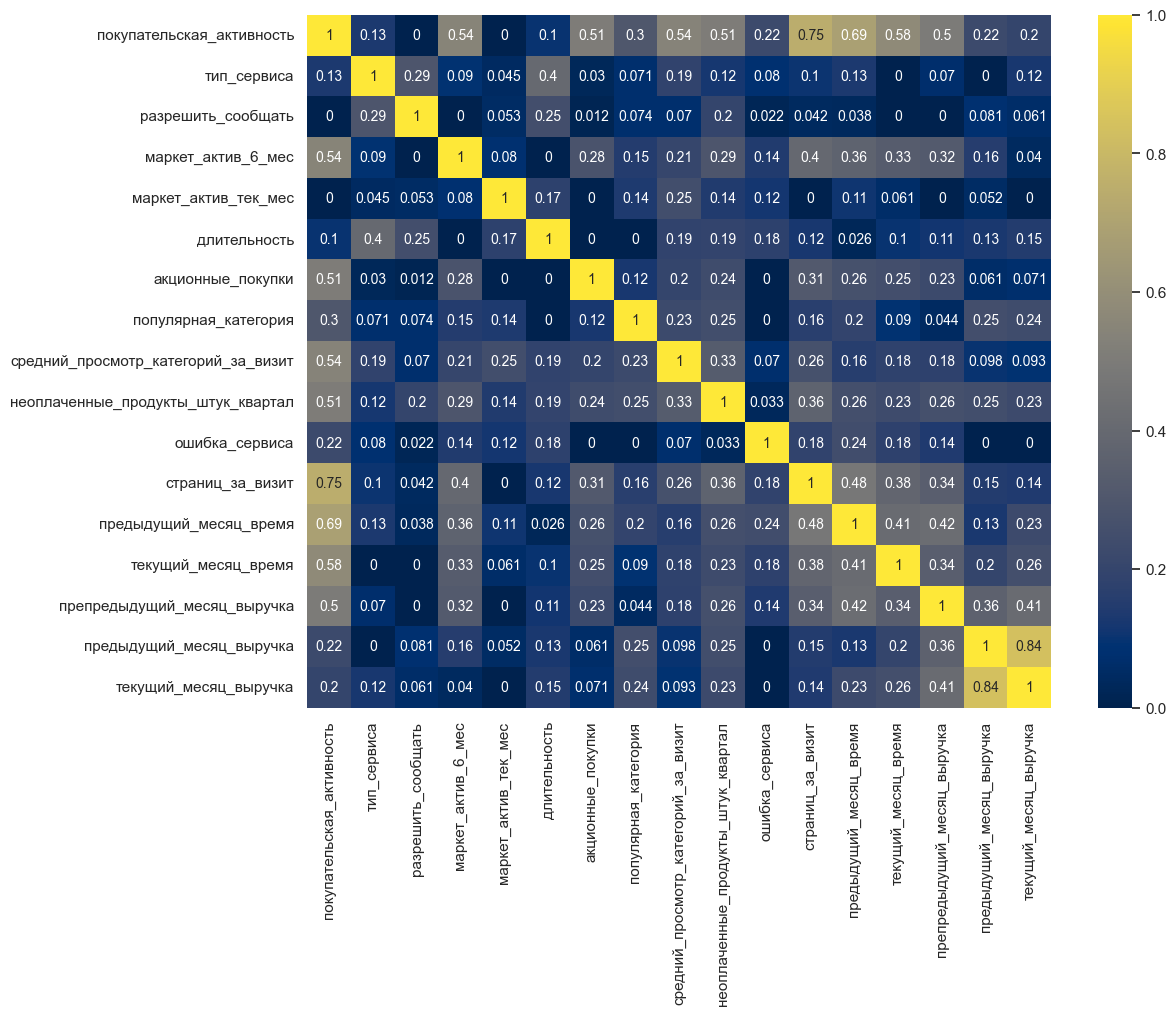

In [81]:
plt.figure(figsize=(12, 9))

sns.heatmap(
    data_full.phik_matrix(interval_cols=numeric_columns),
    annot=True, cmap='cividis',
    annot_kws={'fontsize': 10}
)

plt.show()

Посмотрим, есть ли что-либо примечательное между целевым и остальными признаками

### Корреляция активности и числовых признаков 

In [82]:
phik_numeric = (
        data_full[np.append(np.array(numeric_columns), 'покупательская_активность')]
        .phik_matrix(interval_cols=numeric_columns)
        .loc['покупательская_активность'].to_frame().T
    )

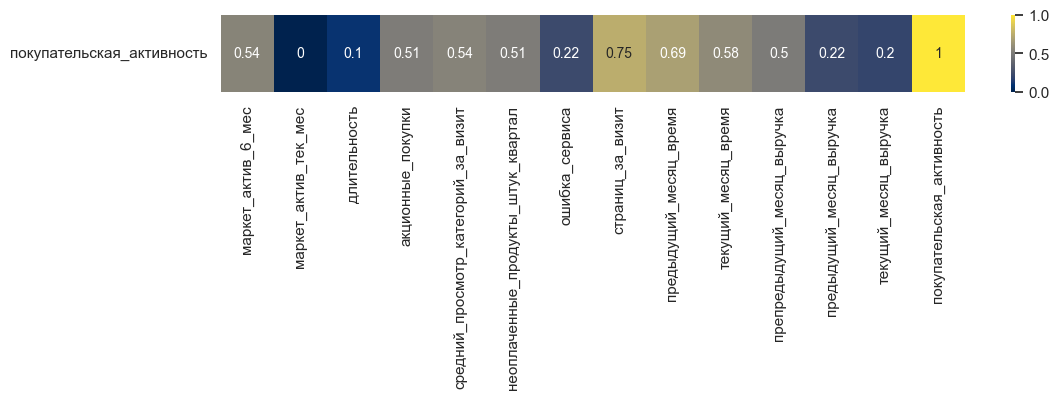

In [83]:
plt.figure(figsize=(12, 1))

sns.heatmap(
    phik_numeric,
    annot=True, cmap='cividis',
    annot_kws={'fontsize': 10}
)
plt.yticks(rotation=0)
plt.show()

Разобьём признаки на несколько групп по коэффициентам зависимости и рассмотрим их отдельно

#### Низкая связь

In [84]:
numeric_low_corr_columns = [col for col in phik_numeric.columns 
                            if phik_numeric.loc['покупательская_активность', col] < 0.3]
numeric_low_corr_columns

['маркет_актив_тек_мес',
 'длительность',
 'ошибка_сервиса',
 'предыдущий_месяц_выручка',
 'текущий_месяц_выручка']

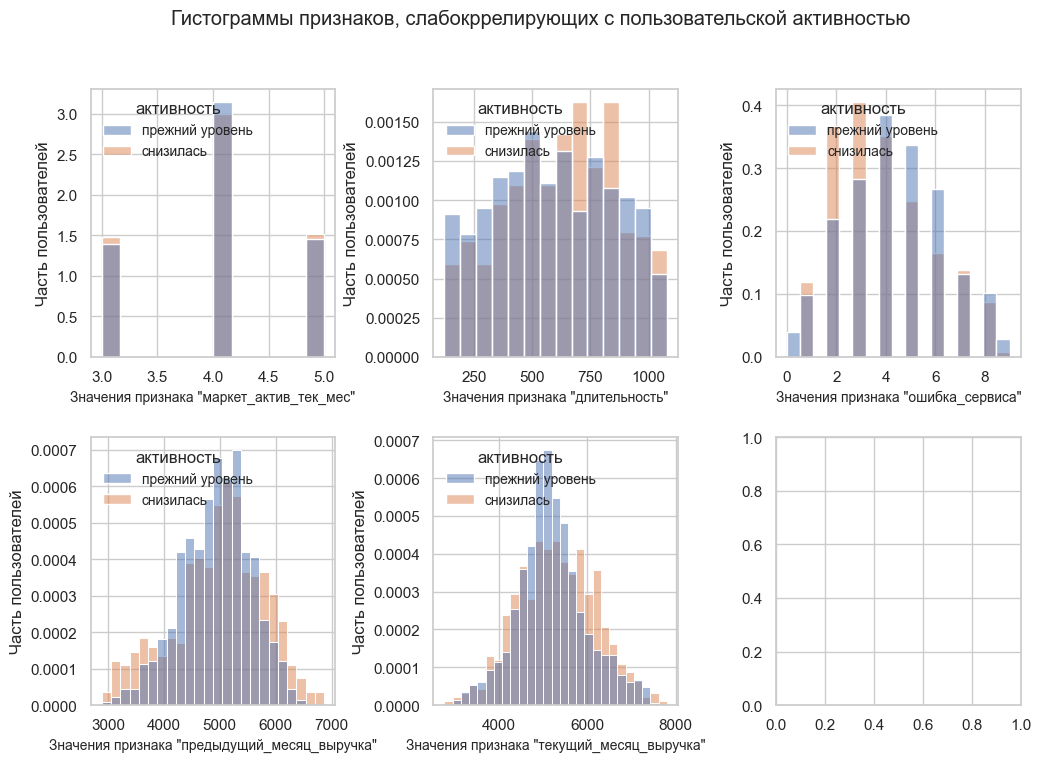

In [85]:
t = 0
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Гистограммы признаков, слабокррелирующих с пользовательской активностью')

for i in range(2):
    for j in range(3):
        sns.histplot(data_full, x=numeric_low_corr_columns[t], hue=target, stat='density', common_norm=False, ax=axes[i, j])
        sns.move_legend(axes[i, j], loc='upper left', fontsize='small', frameon=False, title='активность')
        axes[i, j].set_ylabel('Часть пользователей')
        axes[i, j].set_xlabel(f'Значения признака "{numeric_low_corr_columns[t]}"', fontsize=10)
        t += 1
        if t == 5:
            break
    
fig.subplots_adjust(hspace=0.3, wspace=0.4)
plt.show()

У первых двух видим отсутствие какой-либо связи признаков с активностью, что и соответствует нулевым значениям корреляции.

У остальных трёх значения корреляции ~ 0.2, и здесь уже видим некоторые различия распределений разных активностей: чаще активность отмечается на прежнем уровне для пользователей с более средними значениями выручки; пользователи с прежним уровнем активности чаще сталкиваются с ошибками сервиса (что, однако, может быть связано и со временем, проведённым на сайте).

#### Средняя связь

In [86]:
numeric_medium_corr_columns = [col for col in phik_numeric.columns 
                            if 0.3 < phik_numeric.loc['покупательская_активность', col] < 0.55]
numeric_medium_corr_columns

['маркет_актив_6_мес',
 'акционные_покупки',
 'средний_просмотр_категорий_за_визит',
 'неоплаченные_продукты_штук_квартал',
 'препредыдущий_месяц_выручка']

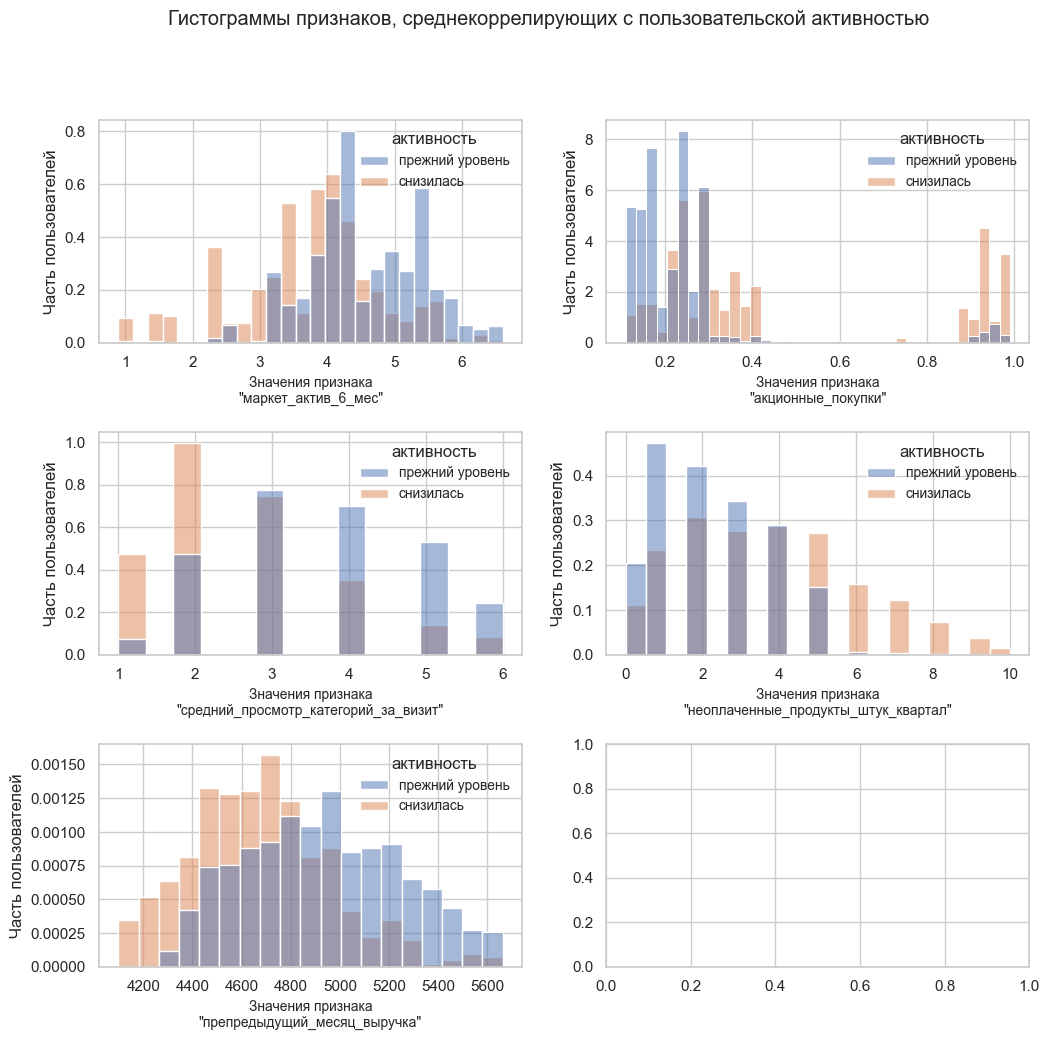

In [87]:
t = 0
fig, axes = plt.subplots(3, 2, figsize=(12, 11))
fig.suptitle('Гистограммы признаков, среднекоррелирующих с пользовательской активностью')

for i in range(3):
    for j in range(2):
        sns.histplot(
            data_full, x=numeric_medium_corr_columns[t], hue=target,
            stat='density', common_norm=False, ax=axes[i, j], bins='auto'
        )
        sns.move_legend(axes[i, j], loc='upper right', fontsize='small', frameon=False, title='активность')
        axes[i, j].set_ylabel('Часть пользователей')
        axes[i, j].set_xlabel(f'Значения признака\n"{numeric_medium_corr_columns[t]}"', fontsize=10)
        t += 1
        if t == 5:
            break
    
fig.subplots_adjust(hspace=0.4, wspace=0.2)
plt.show()

На этих гистограммах отмечаем уже более сильные отличия распределений. В частности, снижением активности значительно чаще характеризуются пользователи, покупавшие товары по акциям с долей от ~ 30%; имевшие в среднем меньше 3 коммуникаций с компанией за полгода; хранившие в корзине число неоплаченных товаров больше 5.

По другим признакам видим снижение активности для пользователей со, в среднем, меньшей выручкой за позапрошлый месяц и меньше просматривавших раличные категории.

Создадим по первым 3 упомянутым бинарные признаки, характеризующие отличия. В дальнейшем рассмотрим, лучше ли их связь с целевым относительно количественных.

Признак низкой активности по коммуникациям за полгода:

In [88]:
(
    data_full[(data_full['покупательская_активность'] == 'прежний уровень') & (data_full['маркет_актив_6_мес'] > 2.6)]
    ['маркет_актив_6_мес'].sort_values().head(5)
)

id
216631    3.0
216154    3.2
216384    3.2
216319    3.2
216440    3.2
Name: маркет_актив_6_мес, dtype: float64

In [89]:
data_full['маркет_актив_6_мес_характер'] = data_full['маркет_актив_6_мес'].apply(
    lambda x: 'низкий' if x < 3.2 else 'нормальный'
)

Признак высокой доли покупок по акциям

In [90]:
for i in np.linspace(0.28, 0.32, num=5, endpoint=True):
    print(f'доля акционных покупок > {i},',
        data_full[data_full['акционные_покупки'] > i]
        ['покупательская_активность'].value_counts() / len(data_full[data_full['акционные_покупки'] > i]), '\n'
    )

доля акционных покупок > 0.28, покупательская_активность
снизилась          0.71
прежний уровень    0.29
Name: count, dtype: float64 

доля акционных покупок > 0.29000000000000004, покупательская_активность
снизилась          0.719
прежний уровень    0.281
Name: count, dtype: float64 

доля акционных покупок > 0.30000000000000004, покупательская_активность
снизилась          0.814
прежний уровень    0.186
Name: count, dtype: float64 

доля акционных покупок > 0.31, покупательская_активность
снизилась          0.814
прежний уровень    0.186
Name: count, dtype: float64 

доля акционных покупок > 0.32, покупательская_активность
снизилась          0.812
прежний уровень    0.188
Name: count, dtype: float64 



In [91]:
data_full['акционные_покупки_степень'] = data_full['акционные_покупки'].apply(
    lambda x: 'высокая' if x > 0.3 else 'низкая'
)

Признак большого числа неоплаченных продуктов

In [92]:
(
    data_full[data_full['неоплаченные_продукты_штук_квартал'] > 5]
    ['покупательская_активность'].value_counts() / len(data_full[data_full['неоплаченные_продукты_штук_квартал'] > 5])
)

покупательская_активность
снизилась          0.946
прежний уровень    0.054
Name: count, dtype: float64

In [93]:
data_full['неоплаченные_продукты_больше_5'] = data_full['неоплаченные_продукты_штук_квартал'].apply(
    lambda x: 'да' if x > 5 else 'нет'
)

In [94]:
data_full.sample(5)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215990           прежний уровень    стандарт                 да   
216164           прежний уровень    стандарт                нет   
216344           прежний уровень     премиум                 да   
216523           прежний уровень    стандарт                 да   
215367                 снизилась     премиум                 да   

        маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215990                 4.7                     4           826   
216164                 4.9                     5           274   
216344                 4.7                     4           597   
216523                 4.0                     3           461   
215367                 4.2                     4           581   

        акционные_покупки                  популярная_категория  \
id                                                                
215990               0.16        техника для красоты и здоровья   
216164               0.21        техника для красоты и здоровья   
216344               0.12                     домашний текстиль   
216523               0.28  мелкая бытовая техника и электроника   
215367               0.40                      товары для детей   

        средний_просмотр_категорий_за_визит  \
id                                            
215990                                    2   
216164                                    3   
216344                                    2   
216523                                    4   
215367                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215990                                   2               6                12   
216164                                   1               9                 4   
216344                                   3               4                16   
216523                                   1               3                 5   
215367                                   1               4                 1   

        предыдущий_месяц_время  текущий_месяц_время  \
id                                                    
215990                      13                   16   
216164                      20                   12   
216344                      17                    9   
216523                      17                    9   
215367                       8                    7   

        препредыдущий_месяц_выручка  предыдущий_месяц_выручка  \
id                                                              
215990                       4997.0                    4966.0   
216164                       4893.0                    4598.0   
216344                       5158.0                    5957.5   
216523                       4416.0                    4153.5   
215367                       4668.0                    5164.5   

        текущий_месяц_выручка маркет_актив_6_мес_характер  \
id                                                          
215990                 5123.3                  нормальный   
216164                 4984.1                  нормальный   
216344                 6780.4                  нормальный   
216523                 4056.0                  нормальный   
215367                 5493.4                  нормальный   

       акционные_покупки_степень неоплаченные_продукты_больше_5  
id                                                               
215990                    низкая                            нет  
216164                    низкая                            нет  
216344                    низкая                            нет  
216523                    низкая                            нет  
215367                   высокая               

#### Высокая связь

In [95]:
numeric_high_corr_columns = [col for col in phik_numeric.columns 
                            if phik_numeric.loc['покупательская_активность', col] > 0.55]
numeric_high_corr_columns

['страниц_за_визит',
 'предыдущий_месяц_время',
 'текущий_месяц_время',
 'покупательская_активность']

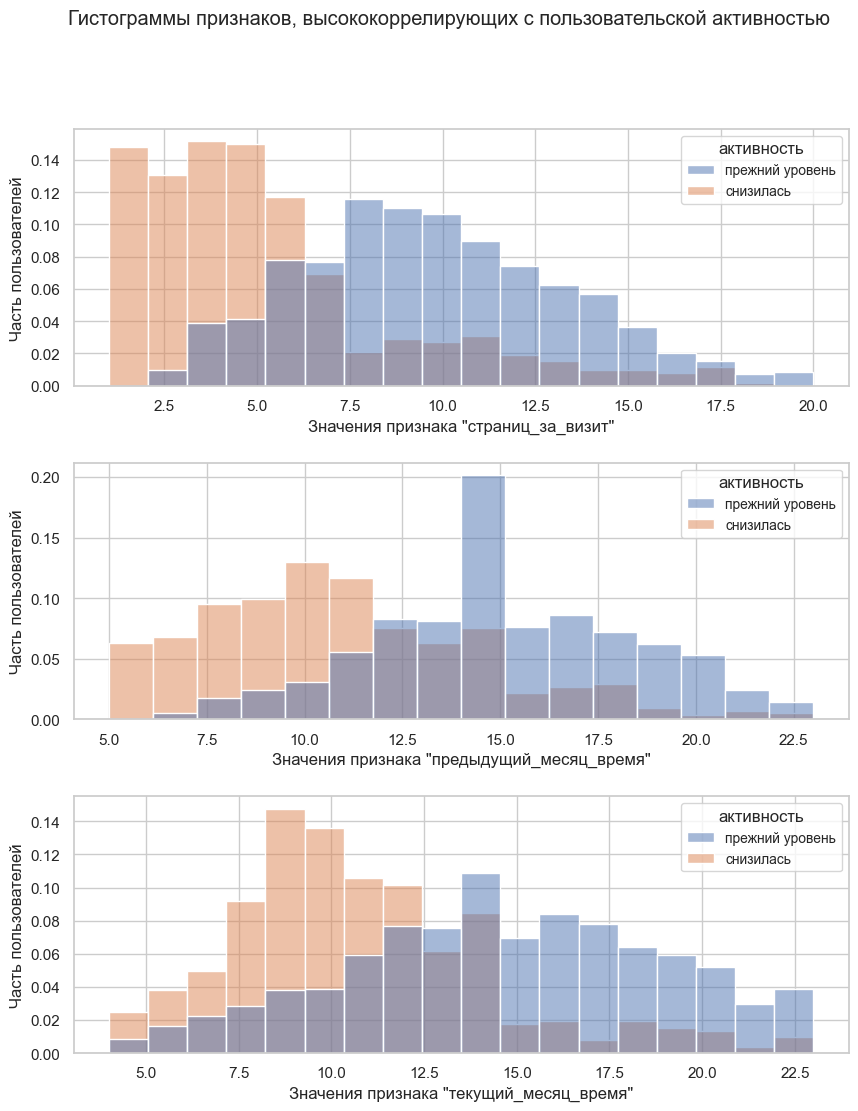

In [96]:
t = 0
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Гистограммы признаков, высококоррелирующих с пользовательской активностью')

for i in range(3):
    sns.histplot(
        data_full, x=numeric_high_corr_columns[t], hue=target,
        stat='density', common_norm=False, ax=axes[i], bins='auto'
    )
    sns.move_legend(axes[i], loc='upper right', fontsize='small', frameon=True, title='активность')
    axes[i].set_ylabel('Часть пользователей')
    axes[i].set_xlabel(f'Значения признака "{numeric_high_corr_columns[t]}"', fontsize=12)
    t += 1
    if t == 5:
        break
    
fig.subplots_adjust(hspace=0.3, wspace=0.2)
plt.show()

По этим признакам вполне очевидно, что пользователи со сниженной активносью менбше времени проводят на сайте и меньше просматривают разных страниц

### Категориальные признаки

In [97]:
phik_categorial = (
        data_full[categorial_columns]
        .phik_matrix()
        .loc['покупательская_активность'].to_frame().T
    )

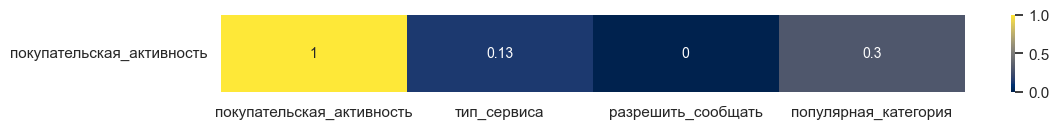

In [98]:
plt.figure(figsize=(12, 1))

sns.heatmap(
    phik_categorial,
    annot=True, cmap='cividis',
    annot_kws={'fontsize': 10}
)
plt.yticks(rotation=0)
plt.show()

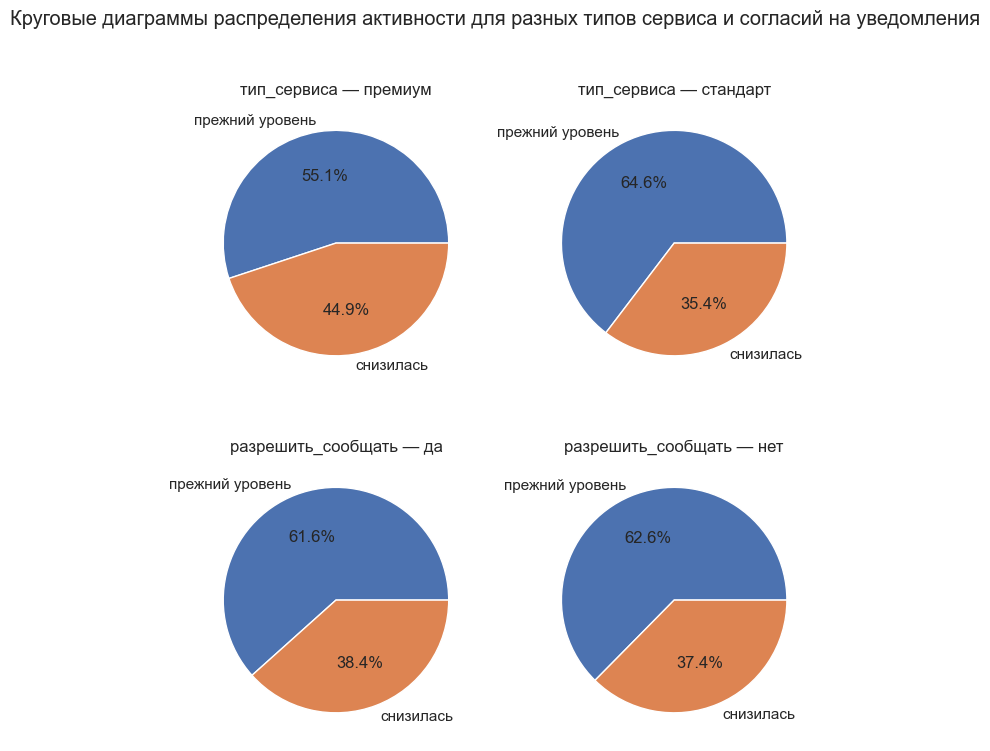

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8.5))
fig.suptitle('Круговые диаграммы распределения активности для разных типов сервиса и согласий на уведомления')

for i in range(2):
    for j in range(2):
        (
            data_full[data_full[categorial_columns[i + 1]] == data_full[categorial_columns[i + 1]].unique()[j]][target]
             .value_counts()
             .plot.pie(autopct='%.1f%%', ax=axes[i, j])
        )
        axes[i, j].set_ylabel('')
        axes[i, j].set_title(f'{categorial_columns[i + 1]} — {data_full[categorial_columns[i + 1]].unique()[j]}')
        
plt.show()

Согласие на уведомления никак не влияет на соотношение, а среди премиального сегмента снижение отмечено для немного большей части, чем для стандартного.

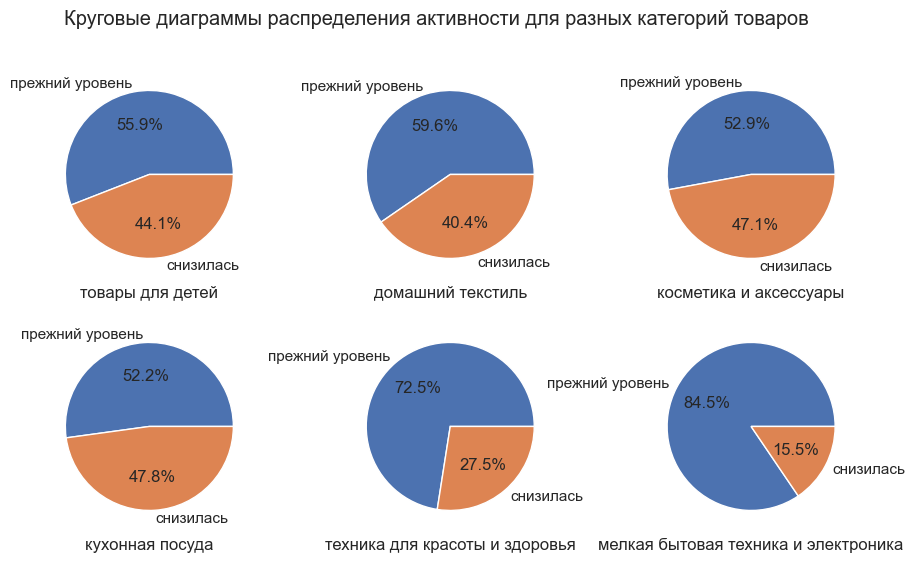

In [100]:
fig, axes = plt.subplots(2, 3, figsize=(11, 6))
fig.suptitle('Круговые диаграммы распределения активности для разных категорий товаров')

for i in range(3):
    (
        data_full[data_full['популярная_категория'] == data_full['популярная_категория'].unique()[i]][target]
        .value_counts()
        .plot.pie(autopct='%.1f%%', ax=axes[0, i])
    )
    axes[0, i].set_ylabel('')
    axes[0, i].set_xlabel(data_full['популярная_категория'].unique()[i])

for i in range(3, 6):
    (
        data_full[data_full['популярная_категория'] == data_full['популярная_категория'].unique()[i]][target]
        .value_counts()
        .plot.pie(autopct='%.1f%%', ax=axes[1, i - 3])
    )
    axes[1, i - 3].set_ylabel('')
    axes[1, i - 3].set_xlabel(data_full['популярная_категория'].unique()[i])

plt.show()

Среди категорий выделяются 2, связанные с техникой: для красоты и здоровья; мелкая бытовая и электроника. Пользователи с этими популярными категориями имеют наименьший среди других уровень снижения активности

### Итог корреляционного анализа

Ещё раз посмотрим на корреляции

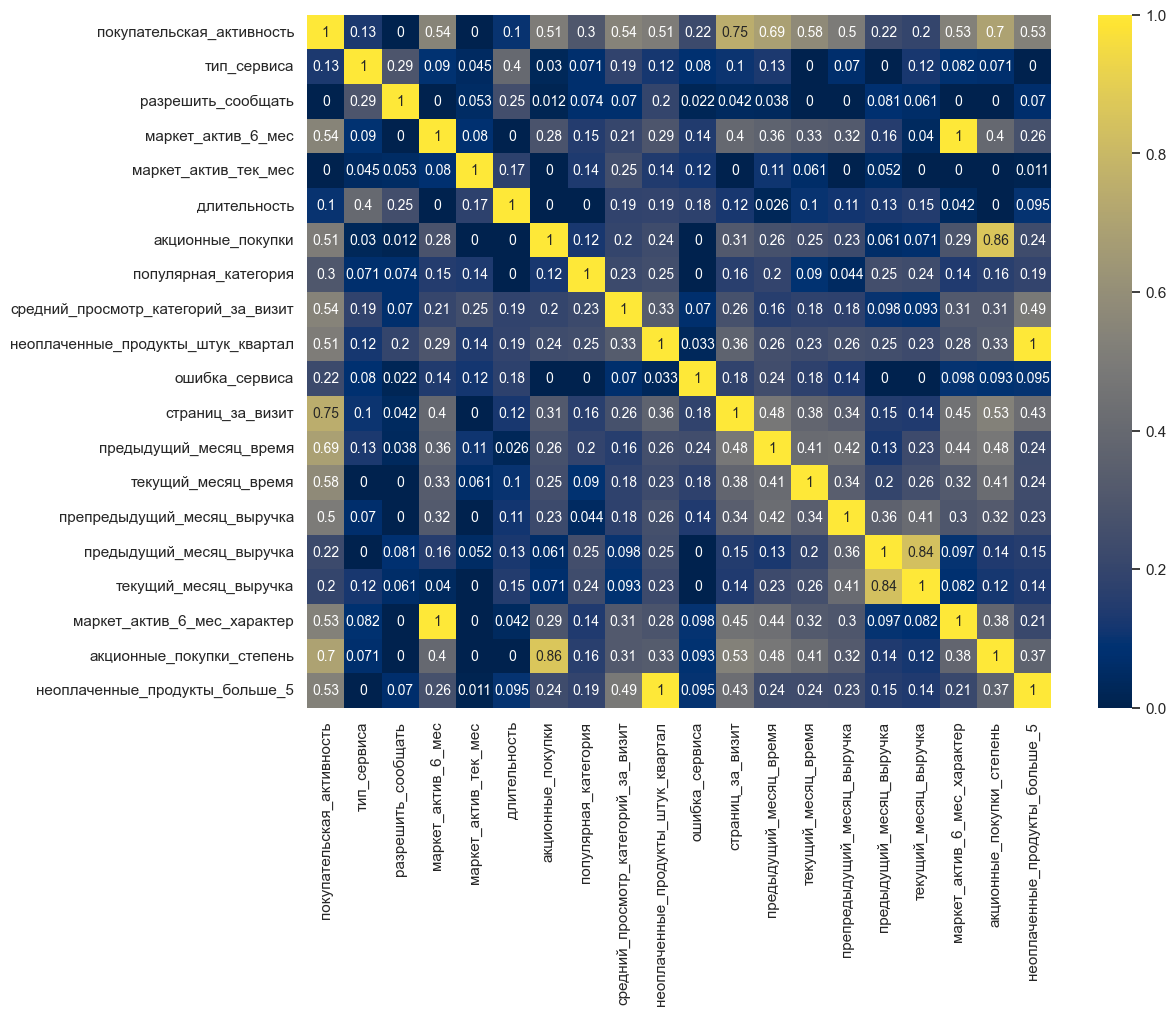

In [101]:
plt.figure(figsize=(12, 9))

sns.heatmap(
    data_full.phik_matrix(interval_cols=numeric_columns),
    annot=True, cmap='cividis',
    annot_kws={'fontsize': 10}
)

plt.show()

Очевидно, что сильно коррелируют между собой новые созданные признаки с их исходными данными. 

Для неоплаченных продуктов и числа уведомлений за полгода корреляция слишком высока, один из каждой пары необходимо убрать. Видим, что старые — количественные — признаки коррелируют с таргетом не хуже новых, поэтому оставим их.

Для пары признаков, связанных с акцией корреляция высока, но не критична. Оставим оба

In [102]:
data_full = data_full.drop(columns=['маркет_актив_6_мес_характер', 'неоплаченные_продукты_больше_5'])

## Подбор модели

### Разделение признаков

Для дальнейшей обработки признаков разделим их на количественные, категориальные номинальные и категориальные ранговые.

Количественные:

In [103]:
data_full.select_dtypes(include='number').head(3)

маркет_актив_6_мес  маркет_актив_тек_мес  длительность  \
id                                                               
215349                 4.4                     4           819   
215350                 4.9                     3           539   
215351                 3.2                     5           896   

        акционные_покупки  средний_просмотр_категорий_за_визит  \
id                                                               
215349               0.75                                    4   
215350               0.14                                    5   
215351               0.99                                    5   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   

        предыдущий_месяц_время  текущий_месяц_время  \
id                                                    
215349                      12                   10   
215350                       8                   13   
215351                      11                   13   

        препредыдущий_месяц_выручка  предыдущий_месяц_выручка  \
id                                                              
215349                       4472.0                    5216.0   
215350                       4826.0                    5457.5   
215351                       4793.0                    6158.0   

        текущий_месяц_выручка  
id                             
215349                 4971.6  
215350                 5058.4  
215351                 6610.4

Некоторые признаки не будем масштабировать: `неоплаченные продукты` и `ошибка сервиса` — их вполне можно характеризовать как раноговые категории.

Ещё 2 признака: `маркет_актив_тек_мес` и `средний просмотр категорий` — закодируем тоже как ранговые категории, чтобы порядок начинался с 0. 

`акционные покупки` вовсе в масштабировании не нуждаются.

In [104]:
scaling_cols = list(data_full.select_dtypes(include='number').drop(
    columns=['маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
             'ошибка_сервиса', 'акционные_покупки']).columns)
scaling_cols

['маркет_актив_6_мес',
 'длительность',
 'страниц_за_визит',
 'предыдущий_месяц_время',
 'текущий_месяц_время',
 'препредыдущий_месяц_выручка',
 'предыдущий_месяц_выручка',
 'текущий_месяц_выручка']

Категориальные:

In [105]:
data_full.select_dtypes(exclude='number').head(3)

покупательская_активность тип_сервиса разрешить_сообщать  \
id                                                                
215349                 снизилась     премиум                 да   
215350                 снизилась    стандарт                нет   
215351                 снизилась    стандарт                 да   

       популярная_категория акционные_покупки_степень  
id                                                     
215349     товары для детей                   высокая  
215350    домашний текстиль                    низкая  
215351     товары для детей                   высокая

Номинальными из перечисленных являются `разрешить_сообщать` и `популярная_категория` — порядок их значений роли не играет

In [106]:
nominal_cat_cols = ['разрешить_сообщать', 'популярная_категория']

Ранговые — `тип сервиса`, `акционные_покупки_степень` и упомянутые ранее `маркет_актив_тек_мес` и `средний просмотр категорий`

In [107]:
ranked_cat_cols = ['тип_сервиса', 'акционные_покупки_степень', 'маркет_актив_тек_мес', 'средний_просмотр_категорий_за_визит']

### Деление на выборки

In [108]:
RANDOM_STATE = 27

In [109]:
X = data_full.drop(columns=target)
y = data_full[target]

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    stratify=y,
    random_state=RANDOM_STATE
)

### Pipeline

Кодируем целевой признак

In [111]:
label_encoder = LabelEncoder()

In [112]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [113]:
label_encoder.classes_

array(['прежний уровень', 'снизилась'], dtype=object)

In [114]:
pd.DataFrame(y_train).value_counts()

0    602
1    370
Name: count, dtype: int64

Пайплайн для OHE-кодирования:

In [115]:
ohe_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(drop='first', sparse_output=False)
        )
    ]
)

Пайплайн для Ordinal-кодирования

In [116]:
for col in ranked_cat_cols:
    print(data_full[col].unique())

['премиум', 'стандарт']
Categories (2, object): ['премиум', 'стандарт']
['высокая' 'низкая']
[4 3 5]
[4 5 3 2 6 1]


In [117]:
ord_pipe = Pipeline(
    [
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['низкая', 'высокая'],
                    [3, 4, 5],
                    [1, 2, 3, 4, 5, 6]
            ]
            )
        )
    ]
)

Полная подготовка:

In [118]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, nominal_cat_cols),
        ('ord', ord_pipe, ranked_cat_cols),
        ('num', StandardScaler(), scaling_cols)
    ],
    remainder='passthrough'
)

Итоговый пайплайн

In [119]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Подбор признаков

Возьмём 4 разных модели: `DecisionTree`, `kNN`, `LogisticRegression` и `SVC` — для каждой из которых задаём ряд гиперпараметров для поиска наилучшего сочетания.

Для дерева это будут макисамльная глубина и минимальные кол-ва примеров в листе и в узле для деления.

Для kNN — различные кол-ва соседей, способы вычисления расстояния, значимости расстояний и способы масштабирования.

Для регрессии — разные виды регуляризации, а также их степени, взвешивание классов и способы масштабирования.

Для SVC — разные ядра, степени регуляризации, взвешивание классов и способы масштабирования.

In [120]:
parameters = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(3, 15),
        'models__min_samples_split': range(3, 15),
        'models__min_samples_leaf': range(3, 15),
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3, 30, 2),
        'models__weights': ['uniform', 'distance'],
        'models__metric': ['minkowski', 'cityblock'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga', max_iter=1000)],
        'models__penalty': ['l1', 'l2'],
        'models__C': np.logspace(-2, 2, 25, endpoint=True),
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf'],
        'models__C': np.logspace(-2, 2, 10, endpoint=True),
        'models__gamma': np.logspace(-2, 2, 10, endpoint=True),
        'models__class_weight': ['balanced', None],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]

Всего получаем 735 разных комбинаций. Возьмём к случайному перебору ~ 10% — 75. 

Исходя из цели исследования, нам необходимо различать как можно больше пользователей со сниженной активностью, подходящая для этого метрика — `recall`. Если ошибочно будут отмечены пользователи и с прежним уровнем активности — не критично. Разве что у компании при низкой `precision` могут вырасти затраты в связи с ошибочными акциями/предложениями. Поэтому параллельно с `recall` взглянем также на `f1`

In [121]:
rs_cv = RandomizedSearchCV(
    pipe_final,
    param_distributions=parameters,
    cv=4,
    scoring=['recall', 'f1'],
    refit='recall',
    n_jobs=-1,
    n_iter=200,
    random_state=RANDOM_STATE
)

In [122]:
rs_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['стандарт',
                                                                                                                            'премиум'],
                                                                                                                           ['низкая',
                                                                                                                            'высокая']...
                                         'models__class_weight': ['balanced',
                                                                  None],
                                         'models__gamma': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                                         'models__kernel': ['linear', 'rbf'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]}],
                   random_state=27, refit='recall', scoring=['recall', 'f1'])

Лучшая модель по `recall`:

In [123]:
rs_cv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['стандарт',
                                                                                               'премиум'],
                                                                                              ['низкая',
                                                                                               'высокая'],
                                                                                              [3,
                                                                                               4,
                                                                                               5],
                                                                                              [1,
                                                                                               2,
                                                                                               3,
                                                                                               4,
                                                                                               5,
                                                                                               6]]))]),
                                                  ['тип_...
                                                   'средний_просмотр_категорий_за_визит']),
                                                 ('num', StandardScaler(),
                                                  ['маркет_актив_6_мес',
                                                   'длительность',
                                                   'страниц_за_визит',
                                                   'предыдущий_месяц_время',
                                                   'текущий_месяц_время',
                                                   'препредыдущий_месяц_выручка',
                                                   'предыдущий_месяц_выручка',
                                                   'текущий_месяц_выручка'])])),
                ('models',
                 LogisticRegression(C=1.467799267622069,
                                    class_weight='balanced', max_iter=1000,
                                    random_state=27, solver='saga'))])

In [124]:
rs_cv.best_params_

{'preprocessor__num': StandardScaler(),
 'models__penalty': 'l2',
 'models__class_weight': 'balanced',
 'models__C': 1.467799267622069,
 'models': LogisticRegression(max_iter=1000, random_state=27, solver='saga')}

Метрики при кросс-валидации и на тесте:

In [125]:
print(f'recall на cv: {rs_cv.best_score_.round(3)}')

y_pred = rs_cv.predict(X_test)

print(f'recall на тестовых данных: {recall_score(y_test, y_pred).round(3)}')

recall на cv: 0.814
recall на тестовых данных: 0.798


Таблица с результатами:

In [126]:
pd.DataFrame(rs_cv.cv_results_).sort_values('rank_test_recall').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
128          0.095         0.007            0.015           0.001   
116          0.227         0.039            0.015           0.002   
33           0.206         0.021            0.025           0.009   
121          0.183         0.032            0.019           0.005   
53           0.053         0.003            0.023           0.011   
7            0.122         0.008            0.018           0.003   
73           0.406         0.045            0.021           0.003   
156          0.764         0.086            0.026           0.002   
88           8.254         3.518            0.023           0.020   
91           6.134         0.814            0.022           0.006   

    param_models__min_samples_split param_models__min_samples_leaf  \
128                             NaN                            NaN   
116                             NaN                            NaN   
33                              NaN                            NaN   
121                             NaN                            NaN   
53                              NaN                            NaN   
7                               NaN                            NaN   
73                              NaN                            NaN   
156                             NaN                            NaN   
88                              NaN                            NaN   
91                              NaN                            NaN   

    param_models__max_depth  \
128                     NaN   
116                     NaN   
33                      NaN   
121                     NaN   
53                      NaN   
7                       NaN   
73                      NaN   
156                     NaN   
88                      NaN   
91                      NaN   

                                          param_models  \
128  LogisticRegression(max_iter=1000, random_state...   
116  LogisticRegression(max_iter=1000, random_state...   
33   LogisticRegression(max_iter=1000, random_state...   
121  LogisticRegression(max_iter=1000, random_state...   
53   LogisticRegression(max_iter=1000, random_state...   
7    LogisticRegression(max_iter=1000, random_state...   
73              SVC(probability=True, random_state=27)   
156             SVC(probability=True, random_state=27)   
88              SVC(probability=True, random_state=27)   
91              SVC(probability=True, random_state=27)   

    param_preprocessor__num param_models__kernel param_models__gamma  \
128        StandardScaler()                  NaN                 NaN   
116          MinMaxScaler()                  NaN                 NaN   
33           MinMaxScaler()                  NaN                 NaN   
121        StandardScaler()                  NaN                 NaN   
53         StandardScaler()                  NaN                 NaN   
7            MinMaxScaler()                  NaN                 NaN   
73           MinMaxScaler()               linear               1.668   
156        StandardScaler()               linear               0.028   
88         StandardScaler()               linear               0.599   
91           MinMaxScaler()               linear              35.938   

    param_models__class_weight param_models__C param_models__penalty  \
128                   balanced           1.468                    l2   
116                   balanced           6.813                    l2   
33                    balanced           3.162                    l2   
121                   balanced           100.0                    l1   
53                    balanced             0.1                    l2   
7                     balanced           0.464                    l2   
73                    balanced           4.642                   NaN   
156                   balanced           4.642                   NaN   
88                    balanced           100.0      

По `f1` результат — 0.817 — не лучший среди всех, но тоже неплохой: `precision` сильно не проседает.

Таким образом пусть случайного подбора лучшей можелью выбираем `LogisticRegression` с гиперпараметрами:
1. `penalty`: l2
2. `class_weight`: balanced
3. `C`: 1.47

Масштабирование: `StandardScaler`

### Итог подобра модели

1. Для корректного масштабирования и кодирования выделили из признаков количественные, категориальные номинальные и категориальные ранговые.
2. Создали `Pipeline`, в котором перебрали 4 модели с различными гиперпараметрами с помощью `RandomizedSearchCV` и выбрали лучшую по метрике `recall`.

## Анализ важности признаков

In [127]:
model = rs_cv.best_estimator_

Подготовим данные для shap

In [128]:
# X_train = pd.DataFrame(
#     data_preprocessor.fit_transform(X_train, y_train), 
#     columns=data_preprocessor.get_feature_names_out()
# )

# X_test = pd.DataFrame(
#     data_preprocessor.transform(X_test),
#     columns=data_preprocessor.get_feature_names_out()
# )

In [129]:
X_train = pd.DataFrame(
    model.named_steps.preprocessor.fit_transform(X_train, y_train), 
    columns=model.named_steps.preprocessor.get_feature_names_out()
)

X_test = pd.DataFrame(
    model.named_steps.preprocessor.transform(X_test),
    columns=model.named_steps.preprocessor.get_feature_names_out()
)

In [130]:
model.named_steps.preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['разрешить_сообщать',
                                  'популярная_категория']),
                                ('ord',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(categories=[['стандарт',
                                                                              'премиум'],
                                                                             ['низкая',
                                                                              'высокая'],
                                                                             [3,
                                                                              4,
                                                                              5],
                                                                             [1,
                                                                              2,
                                                                              3,
                                                                              4,
                                                                              5,
                                                                              6]]))]),
                                 ['тип_сервиса', 'акционные_покупки_степень',
                                  'маркет_актив_тек_мес',
                                  'средний_просмотр_категорий_за_визит']),
                                ('num', StandardScaler(),
                                 ['маркет_актив_6_мес', 'длительность',
                                  'страниц_за_визит', 'предыдущий_месяц_время',
                                  'текущий_месяц_время',
                                  'препредыдущий_месяц_выручка',
                                  'предыдущий_месяц_выручка',
                                  'текущий_месяц_выручка'])])

In [131]:
explainer = shap.LinearExplainer(model.named_steps['models'], X_test)

In [132]:
shap_values = explainer(X_test)

Оценим важность признаков на 2 графиках:

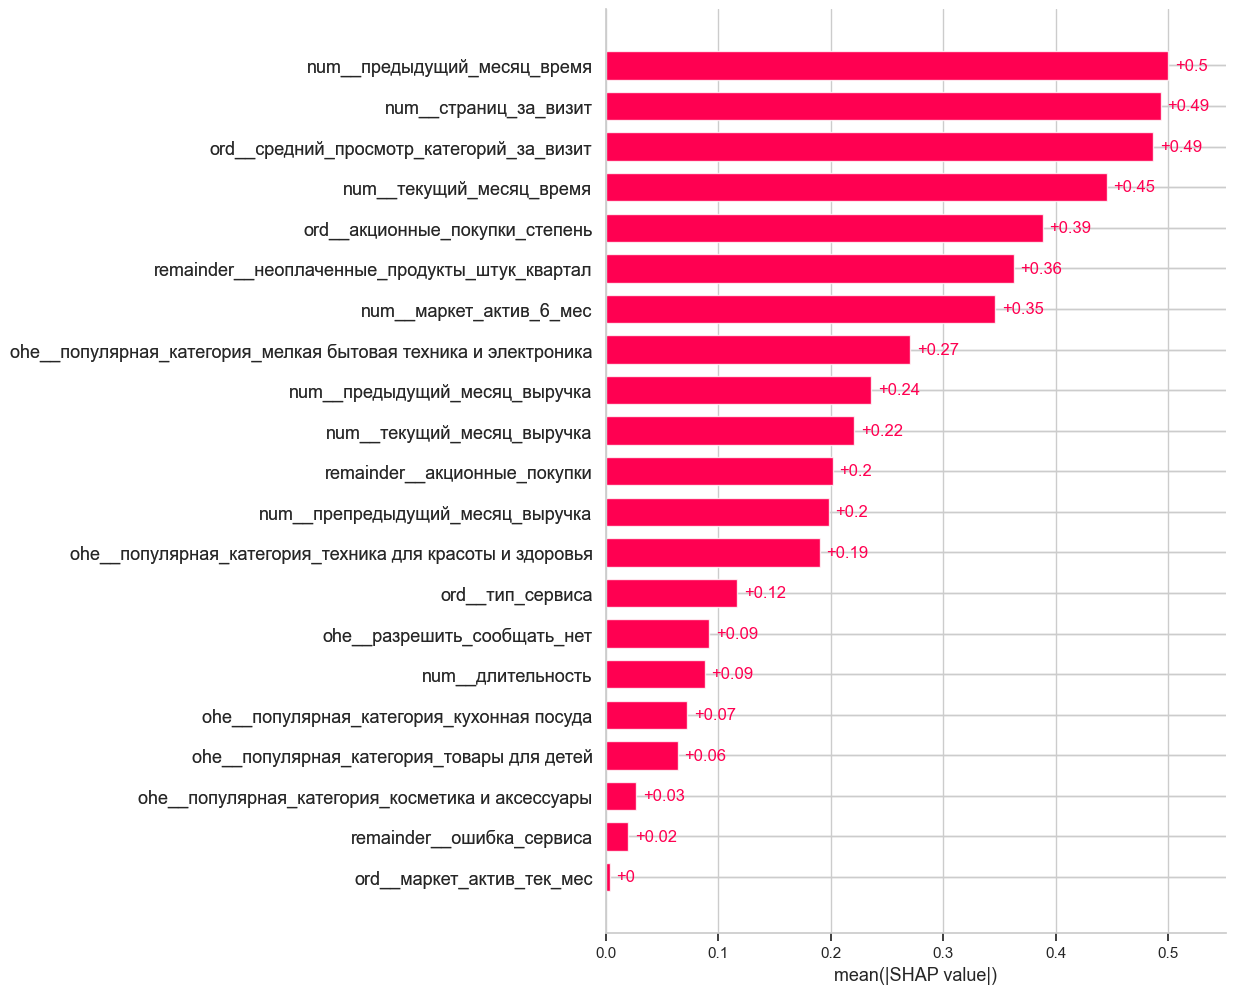

In [133]:
shap.plots.bar(shap_values, max_display=25)

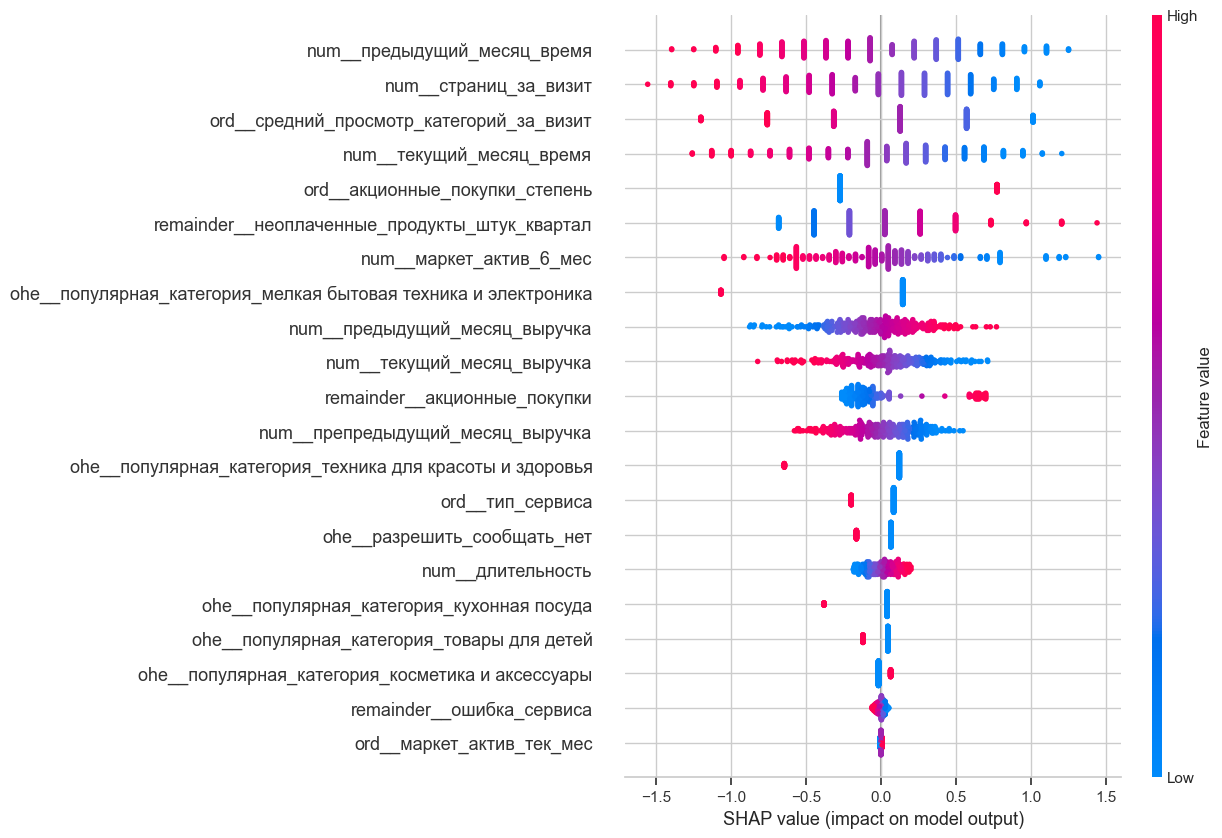

In [134]:
shap.plots.beeswarm(shap_values, max_display=25)

### Итог анализа важности признаков

**Наиболее важные показатели для модели:**
 -  количество просмотренных страниц, различных категорий;
 -  проведённое на сайте время в последние 2 месяца;
 -  среднемесячное значение маркетинговых коммуникаций за полгода

    Эти признаки схожи тем, что **снижение** активности связано с их низкими значениями. Чем ниже, тем признак влияет сильнее, и наоборот.
- число неоплаченных продуктов в корзине: чем их больше, тем вероятность **снижения** тоже больше;
- созданный категориальный признак степени покупок по акциям: влияние на **снижение** высокой доли достаточно высоко. Низкая доля свидетельствует об обратно, но отнюдь не так сильно;
- среди популярных категорий выделяется одна: покупка мелкой бытовой техники и электроники. Её наличие модель соотносит с актиностью **на прежнем уровне** 

    

**Наименее важные показатели:**

- остальные категории товаров;
- тип сервиса, разрешение на уведомления, число сбоев;
- время с момента регистрации, число маркетниговых предложений в текущем месяце

Как эти наблюдения можно использовать для бизнес решений?

По самым влиятельным признакам очевидно, что необходимо увеличивать проведённое на сайте время и/или общее взаимодействие с сайтом. Сюда же отнесём и увеличение предложений, рекомендаций товаров в месяц.

Раз снижение активности наблюдается у клиентов, любящих акции, можно отдельно поискать причины, сопутствующие для них снижению активности.

## Сегментация покупателей

Посмотрим на связь прибыльности покупателей и вероятности снижения их активности.

Добавим в общий датасет `data_full` значения прибыльности и вероятность отнесения клиентов к категории сниженной активности.

In [135]:
X.head()

тип_сервиса разрешить_сообщать  маркет_актив_6_мес  \
id                                                          
215349     премиум                 да                 4.4   
215350    стандарт                нет                 4.9   
215351    стандарт                 да                 3.2   
215352    стандарт                нет                 5.1   
215353    стандарт                 да                 3.3   

        маркет_актив_тек_мес  длительность  акционные_покупки  \
id                                                              
215349                     4           819               0.75   
215350                     3           539               0.14   
215351                     5           896               0.99   
215352                     3          1064               0.94   
215353                     4           762               0.26   

       популярная_категория  средний_просмотр_категорий_за_визит  \
id                                                                 
215349     товары для детей                                    4   
215350    домашний текстиль                                    5   
215351     товары для детей                                    5   
215352     товары для детей                                    3   
215353    домашний текстиль                                    4   

        неоплаченные_продукты_штук_квартал  ошибка_сервиса  страниц_за_визит  \
id                                                                             
215349                                   4               2                 5   
215350                                   2               1                 5   
215351                                   0               6                 4   
215352                                   2               3                 2   
215353                                   1               1                 4   

        предыдущий_месяц_время  текущий_месяц_время  \
id                                                    
215349                      12                   10   
215350                       8                   13   
215351                      11                   13   
215352                       8                   11   
215353                      10                   10   

        препредыдущий_месяц_выручка  предыдущий_месяц_выручка  \
id                                                              
215349                       4472.0                    5216.0   
215350                       4826.0                    5457.5   
215351                       4793.0                    6158.0   
215352                       4594.0                    5807.5   
215353                       5124.0                    4738.5   

        текущий_месяц_выручка акционные_покупки_степень  
id                                                       
215349                 4971.6                   высокая  
215350                 5058.4                    низкая  
215351                 6610.4                   высокая  
215352                 5872.5                   высокая  
215353                 5388.5                    низкая

Преобразуем признаки для передачи их модели

In [136]:
y_transformed = label_encoder.transform(y)

X_transformed = pd.DataFrame(
    model.named_steps.preprocessor.transform(X), 
    columns=model.named_steps.preprocessor.get_feature_names_out()
)

In [137]:
y_transformed[:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [138]:
X_transformed.head(3)

ohe__разрешить_сообщать_нет  \
0                          0.0   
1                          1.0   
2                          0.0   

   ohe__популярная_категория_косметика и аксессуары  \
0                                               0.0   
1                                               0.0   
2                                               0.0   

   ohe__популярная_категория_кухонная посуда  \
0                                        0.0   
1                                        0.0   
2                                        0.0   

   ohe__популярная_категория_мелкая бытовая техника и электроника  \
0                                                0.0                
1                                                0.0                
2                                                0.0                

   ohe__популярная_категория_техника для красоты и здоровья  \
0                                                0.0          
1                                                0.0          
2                                                0.0          

   ohe__популярная_категория_товары для детей  ord__тип_сервиса  \
0                                         1.0               1.0   
1                                         0.0               0.0   
2                                         1.0               0.0   

   ord__акционные_покупки_степень  ord__маркет_актив_тек_мес  \
0                             1.0                        1.0   
1                             0.0                        0.0   
2                             1.0                        2.0   

   ord__средний_просмотр_категорий_за_визит  num__маркет_актив_6_мес  \
0                                       3.0                    0.137   
1                                       4.0                    0.635   
2                                       4.0                   -1.060   

   num__длительность  num__страниц_за_визит  num__предыдущий_месяц_время  \
0              0.858                 -0.803                       -0.370   
1             -0.259                 -0.803                       -1.394   
2              1.166                 -1.052                       -0.626   

   num__текущий_месяц_время  num__препредыдущий_месяц_выручка  \
0                    -0.764                            -1.080   
1                    -0.052                            -0.017   
2                    -0.052                            -0.116   

   num__предыдущий_месяц_выручка  num__текущий_месяц_выручка  \
0                          0.405                      -0.303   
1                          0.745                      -0.199   
2                          1.734                       1.665   

   remainder__акционные_покупки  \
0                          0.75   
1                          0.14   
2                          0.99   

   remainder__неоплаченные_продукты_штук_квартал  remainder__ошибка_сервиса  
0                                            4.0                        2.0  
1                                            2.0                        1.0  
2                                            0.0                        6.0

Получаем вероятности

In [139]:
probas = model.named_steps['models'].predict_proba(X_transformed)[:, 1]

C:\Users\vanik\anaconda3\envs\practicum\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [140]:
probas[:10]

array([0.93933206, 0.50569575, 0.87713132, 0.97183956, 0.72973336,
       0.88135551, 0.27701655, 0.9558797 , 0.45456662, 0.81876386])

Из данных о прибыльности убираем ранее удалённые значения с нулевой выручкой

In [141]:
last_quarter_income_data = last_quarter_income_data[last_quarter_income_data['id'].isin(data_full.index)]
last_quarter_income_data = last_quarter_income_data.reset_index(drop=True)
last_quarter_income_data['вероятность_снижения'] = probas

Объединяем со всеми данными

In [142]:
data_full = data_full.merge(last_quarter_income_data, on='id', how='left')

In [143]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   id                                   1296 non-null   int64   
 1   покупательская_активность            1296 non-null   category
 2   тип_сервиса                          1296 non-null   category
 3   разрешить_сообщать                   1296 non-null   category
 4   маркет_актив_6_мес                   1296 non-null   float64 
 5   маркет_актив_тек_мес                 1296 non-null   int64   
 6   длительность                         1296 non-null   int64   
 7   акционные_покупки                    1296 non-null   float64 
 8   популярная_категория                 1296 non-null   category
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64   
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64   
 11  ошибка_сервиса   

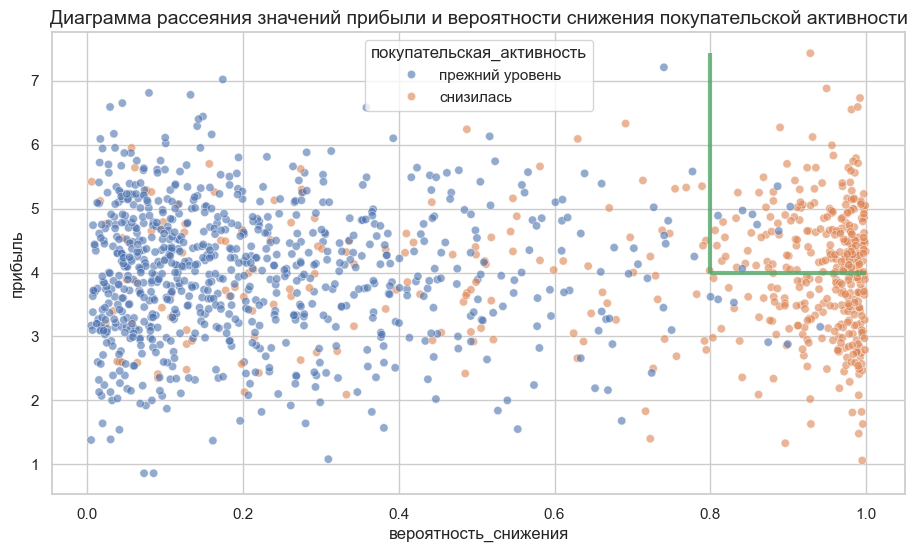

In [144]:
plt.subplots(figsize=(11, 6))

sns.scatterplot(data_full, y='прибыль', x='вероятность_снижения', hue='покупательская_активность', alpha=0.6)
plt.vlines(x=0.8, ymin=4, ymax=data_full['прибыль'].max(), color='g', lw=3, alpha=0.8)
plt.hlines(y=4, xmin=0.8, xmax=1, color='g', lw=3, alpha=0.8)

plt.title('Диаграмма рассеяния значений прибыли и вероятности снижения покупательской активности', fontsize=14)
plt.show()

In [145]:
data_full['прибыль'].median()

4.045

По плоности точек видим, что большую часть пользователей модель распределила достаточно уверенно: наибольшие скопления отмечаются ниже 0.2 и выше 0.8. Активность снижается как для высокоприбыльных пользователей, так и для остальных.

Рассмотрим часть наиболее прибыльных клиентов (примем порог ~ равным медиане — 4) с высокой вероятностью снижения покупательской активности (более 0.8).

In [146]:
len(data_full.query('прибыль > 4 and вероятность_снижения > 0.8'))

194

Рассчитаем также в данных информацию об измении выручки и проведённого на сайте времени между разными месяцами 

In [147]:
data_full['выручка_разница_21'] = data_full['предыдущий_месяц_выручка'] - data_full['препредыдущий_месяц_выручка']
data_full['выручка_разница_32'] = data_full['текущий_месяц_выручка'] - data_full['предыдущий_месяц_выручка']
data_full['выручка_разница_31'] = data_full['текущий_месяц_выручка'] - data_full['препредыдущий_месяц_выручка']
data_full['время_разница'] = data_full['текущий_месяц_время'] - data_full['предыдущий_месяц_время']

In [148]:
segment_data = data_full.query('прибыль > 4 and вероятность_снижения > 0.8')

Встречаемость популярных категорий:

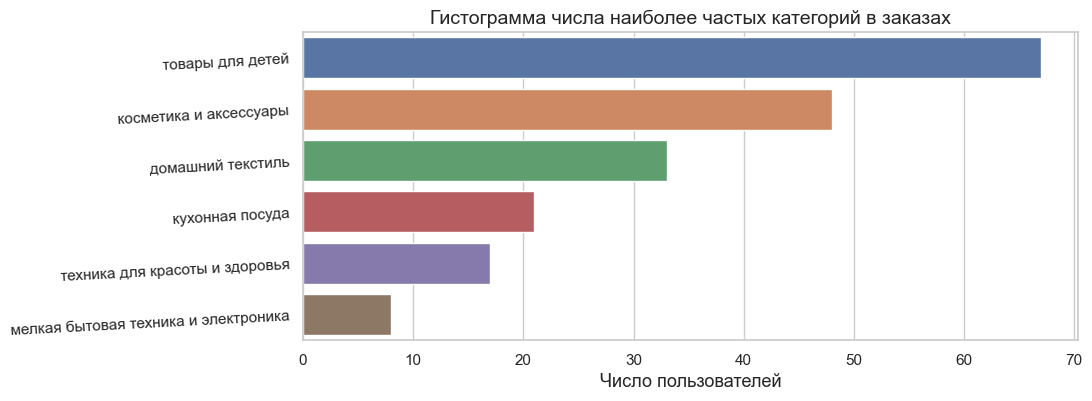

In [149]:
plt.figure(figsize=(10, 4))

sns.barplot(segment_data['популярная_категория'].value_counts().to_frame().T,
    orient='h')
plt.xlabel('Число пользователей', fontsize=13)
plt.ylabel('')
plt.title("Гистограмма числа наиболее частых категорий в заказах", fontsize=14)
plt.tick_params(axis='y', rotation=3)

plt.show()

В п. 3.2 рассматривали распределение категорий по всем данным, теперь же видим некоторые отличия для выбранных пользователей.

Товары для детей и косметика встречаются чаще, чем в распределении всех данных.

In [150]:
revenue = ['препредыдущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_выручка']
revenue_diff = ['выручка_разница_21', 'выручка_разница_32', 'выручка_разница_31']

Средняя выручка по категориям товаров:

In [151]:
segment_pivot = segment_data.pivot_table(
    index='популярная_категория', 
    values=revenue,
    aggfunc='mean'
)[revenue].round()

In [152]:
segment_pivot

препредыдущий_месяц_выручка  \
популярная_категория                                                
домашний текстиль                                          4584.0   
косметика и аксессуары                                     4589.0   
кухонная посуда                                            4618.0   
мелкая бытовая техника и электроника                       4554.0   
техника для красоты и здоровья                             4542.0   
товары для детей                                           4607.0   

                                      предыдущий_месяц_выручка  \
популярная_категория                                             
домашний текстиль                                       5204.0   
косметика и аксессуары                                  5179.0   
кухонная посуда                                         5365.0   
мелкая бытовая техника и электроника                    5230.0   
техника для красоты и здоровья                          4230.0   
товары для детей                                        4678.0   

                                      текущий_месяц_выручка  
популярная_категория                                         
домашний текстиль                                    5559.0  
косметика и аксессуары                               5599.0  
кухонная посуда                                      5796.0  
мелкая бытовая техника и электроника                 5414.0  
техника для красоты и здоровья                       4564.0  
товары для детей                                     4955.0

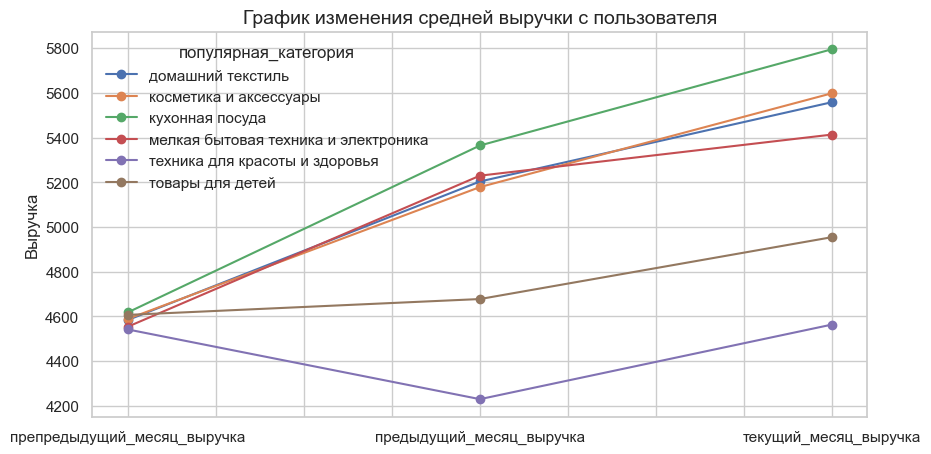

In [153]:
fig, axes = plt.subplots(figsize=(10, 5))

segment_pivot.T.plot(ax=axes, style='o-')

sns.move_legend(axes, loc='upper left', frameon=False)
plt.title('График изменения средней выручки с пользователя', fontsize=14)
plt.ylabel('Выручка')
plt.show()

Наблюдаем неуверенный рост у `товаров для детей` и стагнацию `техники для красоты и здоровья`.

Посмотрим на диаграммы размаха значений разниц в выручке между месяцами:

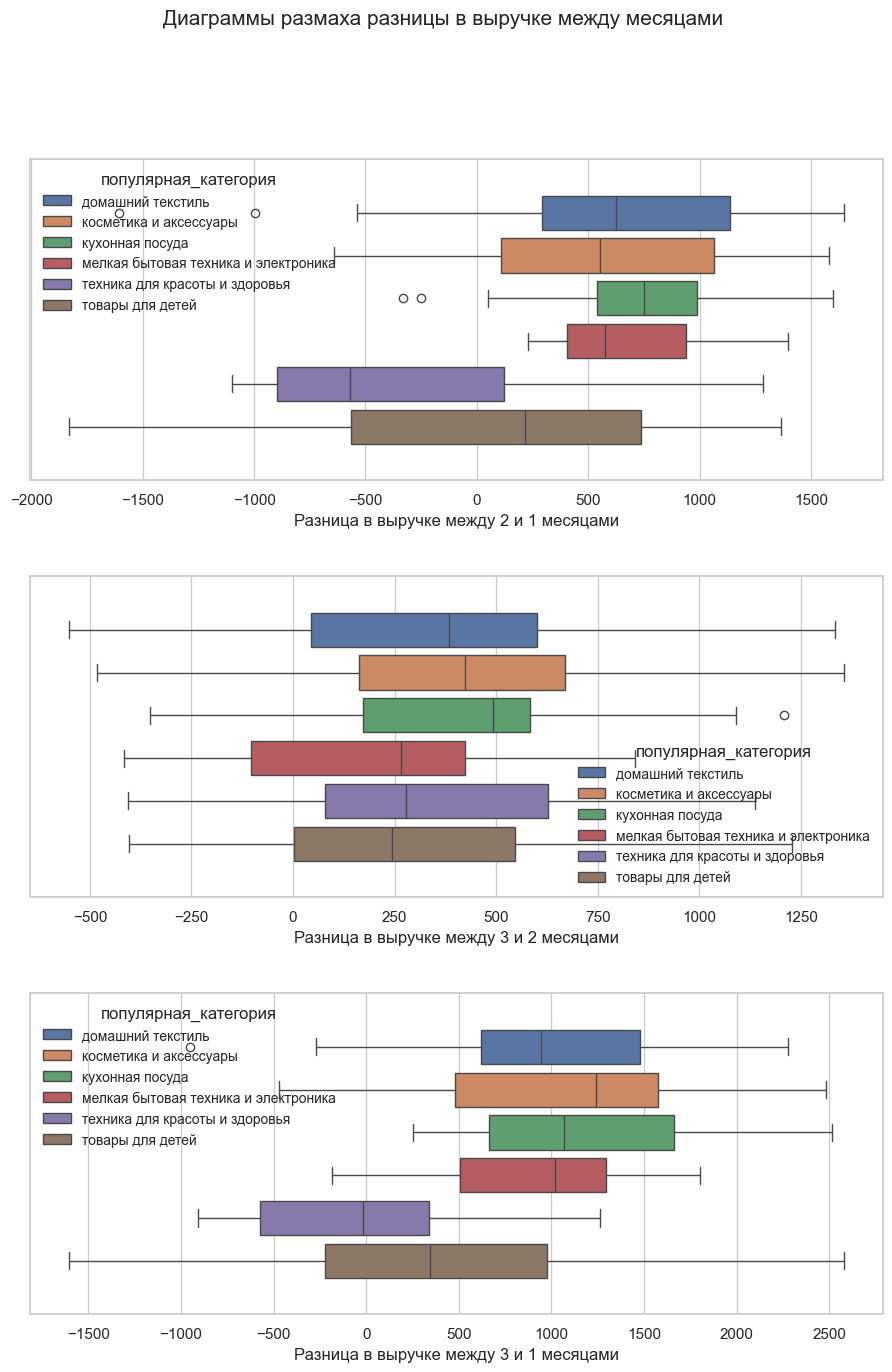

In [154]:
_diff = ['2 и 1 месяцами', '3 и 2 месяцами', '3 и 1 месяцами']

fig, axes = plt.subplots(3, 1, figsize=(11, 15))
plt.suptitle('Диаграммы размаха разницы в выручке между месяцами', fontsize=15)

for i  in range(3):
    sns.boxplot(segment_data, x=revenue_diff[i], hue='популярная_категория', ax=axes[i], gap=0.2, orient='h')
    sns.move_legend(axes[i], loc='best', fontsize='small', frameon=False)
    axes[i].set_xlabel(f'Разница в выручке между {_diff[i]}')

plt.subplots_adjust(hspace=0.3)
plt.xticks(range(-1500, 3000, 500))
plt.show()

Между первыми месяцами выручка снижалась у большой части пользователей из категорий `товары для детей` и `техника для красоты`.

Между следющими меcяцами для этих категорий снижение выручки у ощутимо меньшей части, однако произошло общее снижение выручки ~ для 25% в каждой из друних категорий. У всех большая часть, а то и весь левый ус отрицателен.

Между 3 и 2 месяцами видим "средний" рост для всех категорий, но и у каждой левый ус отрицателен, т.е. у ~25% пользователей.

В итоге между 3 и 1 месяцами отрицательна разница в выручке всё же только для большой части 2 категорий.

Разница в проведённом времени:

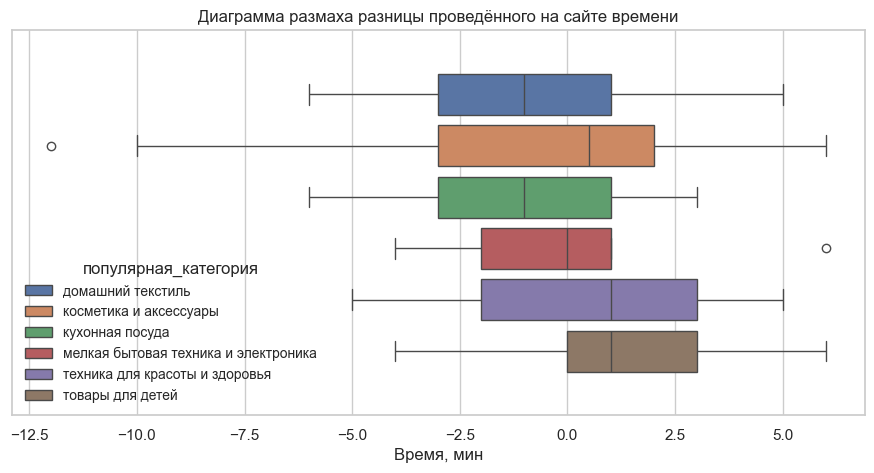

In [155]:
fig, axes = plt.subplots(1, 1, figsize=(11, 5))

sns.boxplot(segment_data, x='время_разница', hue='популярная_категория', ax=axes, gap=0.2, orient='h')
sns.move_legend(axes, loc='best', fontsize='small', frameon=False)

plt.title('Диаграмма размаха разницы проведённого на сайте времени')
plt.xlabel('Время, мин')
plt.show()

Только что отмечали, что между 3 и 2 месяцами произошёл спад в выручке у 4 категорий — вемсте с этим наблюдаем и значительное снижение времени на сайте у ещё большей доли для этих категорий (50% и более).

**Суммируем наблюдения по сегменту покупателей:**

- самые встречаемые категории — товары для детей и косметика;
- средняя выручка растёт ежемесячно практически по каждой категории, однако есть и провалы снижения для немалой части пользователей;
- между первыми месяцами провалы были у детских товаров и у техники для красоты. К последнему месяцу выручка снова выросла. Техника для красоты — довольно редкая категория для выбранной группы пользователей. На её изменения стоит смотреть осторожно;
- у других 4 категорий видим рост выручки для подавляющего большинства пользователей между первыми месяцами, между следующими есть снижение выручки для ~ 25% пользователей. Параллельно видим у этих категорий снижение времени, проведённого на сайте, у половины и более пользователей.

Провалы в выручке от пользователей могут обуславливаться и независящими от магазина причинами: длительностью жизни товара, цикличностью его обновления, сезонными виляниями и проч. Если же такая связь не обнаруживается, можно предложить следующее:
1. Вернуть внимание пользователей, а вместе с этим и проводимое на сайте время, бОльшим числом рекомендаций по категориям с уменьшающимся временем.
2. Для `детских товаров` — самой неуспешной и многочисленной категории в группе — увеличить внимание пользователей персональными акциями.

## Общий вывод

1. В нескольких файлых предоставлены данные о финансовом продуктовом поведении пользователей, взаимодействии с ним сервиса за последние месяцы.
2. В заполнении данных обнаружены грамматические ошибки, приводящие к дублированию различных категорий.
3. Исследовательский анализ отсеял 4 пользотелей, у которых не было активности в исследуемых промежутках, либо очень значительно по ней выделяющихся.
4. В корреляционном анализе рассмотрели влияние признаков на целевой.
5. Для подбора лучшей модели применили масштабирование ряда количественных признаков, кодирование категориальных. Модель подбиралась непосредственно из 4: `DecisionTree`, `kNN`, `LogisticRegression` и `SVC` — с различными гиперпараметрами для каждой.
6. Лучше всех по метрике `recall` себя показала `LogisticRegression` с гиперпараметрами:
    - `penalty`: l2
    - `class_weight`: balanced
    - `C`: 1.47
7. Исследован сегмент покупателей с наибольшей выручкой и с наибольшей вероятностью снижения их покупательской активности. Возможные варианты поднятия их активности:

   7.1. Вернуть внимание пользователей, а вместе с этим и проводимое на сайте время, бОльшим числом рекомендаций по категориям с уменьшающимся временем.

   7.2. Для `детских товаров` — самой неуспешной и многочисленной категории в группе — увеличить внимание пользователей персональными акциями.